<h1>Rachunek prawdopodobieństwa i statystyka</h1>


<h3>Piotr Śmiałek</h3>

**Poniższy notebook zawiera analizę dystrybucji zwrotów (DoR), która  jest istotna dla podejmowania decyzji inwestycyjnych, oceny ryzyka, i budowania bardziej precyzyjnych modeli prognoz finansowych .**

Do pobrania danych finansowych wykorzystam API yfinance, która umożliwi mi pobieranie historycznych danych instrumentów finansowych z yahoofinance
Wiecej informacji:
https://pypi.org/project/yfinance/

In [ ]:
!pip install yfinance

<h3>Importowanie niezbędnych bibliotek </h3>

In [302]:
import yfinance as yf
import sqlite3
import numpy as np
import pandas as pd
import matplotlib as mplt
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
from tabulate import tabulate
%matplotlib inline

<h3>Importowanie danych</h3>

Do importowania danych z bazy użyję funkcji:

In [303]:
def import_data(symbol, database_name, data_intervals):
    data = yf.download(symbol, period="max", interval=data_intervals)
    conn = sqlite3.connect("./data/" + database_name)
    data.to_sql(name=symbol, con=conn , if_exists="replace", index=True)
    conn.close()

Za pomocą powyższej funkcji bedę mógł stworzyć osobne zbiory danych dla podanego instrumentów finansowego, dla interwałów:
dniowego, tygodniowego, miesięcznego i kwartalnego.

In [304]:
import_data("MSFT", "microsoft_daily.db", "1d")
import_data("MSFT", "microsoft_weekly.db", "1wk")
import_data("MSFT", "microsoft_monthly.db", "1mo")
import_data("MSFT", "microsoft_quarterly.db", "3mo")

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Poniższa funkcja umożliwi mi pracę z danymi za pomocą bibioteki pandas, które na razie są zapisane w bazie SQLite.

In [305]:
def convert_to_dataframe(symbol,database_path):
    conn = sqlite3.connect(database_path)
    query = f"SELECT * FROM {symbol}"
    df = pd.read_sql(query, conn)
    conn.close()
    return df

Konwersja danych do DataFrame

In [306]:
df_microsoft_daily = convert_to_dataframe("MSFT", "./data/microsoft_daily.db")
df_microsoft_weekly = convert_to_dataframe("MSFT", "./data/microsoft_weekly.db")
df_microsoft_monthly = convert_to_dataframe("MSFT", "./data/microsoft_monthly.db")
df_microsoft_quarterly = convert_to_dataframe("MSFT", "./data/microsoft_quarterly.db")

Każda z wczytanych tabel posiada 7 kolumn:
- Date

- Open - otwarcie to cena instrumentu finansowego (takiego jak akcje) w momencie otwarcia sesji handlowej na rynku. Oznacza to, ile jednostek waluty trzeba było zapłacić lub otrzymać w zamian za jednostkę instrumentu finansowego napoczątku sesji.

- High - najwyższa cena instrumentu finansowego osiągnięta w trakcie danego okresu czasu (np. jednej sesji handlowej). To jest największa wartość, którą osiągnęła cena w danym przedziale czasowym.

- Low - najniższa cena instrumentu finansowego osiągnięta w trakcie danego okresu czasu. To jest najmniejsza wartość, którą osiągnęła cena w danym przedziale czasowym.

- Close - cena instrumentu finansowego w momencie zamknięcia sesji handlowej. Oznacza to, ile jednostek waluty trzeba było zapłacić lub otrzymać w zamian za jednostkę instrumentu finansowego na końcu sesji.

- Adj Close - cena instrumentu finansowego w momencie zamknięcia sesji handlowej. Oznacza to, ile jednostek waluty trzeba było zapłacić lub otrzymać w zamian za jednostkę instrumentu finansowego na końcu sesji. Jest zmodyfikowaną ceną zamknięcia, która uwzględnia różne korekty i dostosowania, takie jak dywidendy, podziały akcji i zdarzenia korporacyjne.

- Volume - wolumen to liczba jednostek instrumentu finansowego, które zostały wymienione w danym okresie czasu. Oznacza to, ile razy dany instrument finansowy został kupiony lub sprzedany w danym przedziale czasowym.

Sprawdzenie poprawności wczytanych danych:

In [307]:
df_microsoft_daily.shape

(9542, 7)

In [308]:
df_microsoft_weekly.shape

(1977, 7)

In [309]:
df_microsoft_monthly.shape

(454, 7)

In [310]:
df_microsoft_quarterly.shape

(153, 7)

In [311]:
df_microsoft_daily.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1986-03-13 00:00:00,0.088542,0.101563,0.088542,0.097222,0.060274,1031788800
1,1986-03-14 00:00:00,0.097222,0.102431,0.097222,0.100694,0.062427,308160000
2,1986-03-17 00:00:00,0.100694,0.103299,0.100694,0.102431,0.063504,133171200
3,1986-03-18 00:00:00,0.102431,0.103299,0.098958,0.099826,0.061889,67766400
4,1986-03-19 00:00:00,0.099826,0.100694,0.097222,0.098090,0.060812,47894400


In [312]:
df_microsoft_weekly.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1986-03-10 00:00:00,0.088542,0.102431,0.088542,0.100694,0.062427,1339948800
1,1986-03-17 00:00:00,0.100694,0.103299,0.091146,0.092882,0.057583,367257600
2,1986-03-24 00:00:00,0.092882,0.096354,0.089410,0.096354,0.059736,136972800
3,1986-03-31 00:00:00,0.096354,0.098958,0.093750,0.096354,0.059736,100598400
4,1986-04-07 00:00:00,0.096354,0.101563,0.092882,0.099826,0.061889,70070400


In [313]:
df_microsoft_monthly.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1986-04-01 00:00:00,0.095486,0.121962,0.092882,0.111979,0.069423,547142400
1,1986-05-01 00:00:00,0.111979,0.123264,0.107639,0.121528,0.075343,333446400
2,1986-06-01 00:00:00,0.121528,0.121528,0.102431,0.106771,0.066194,293788800
3,1986-07-01 00:00:00,0.106771,0.109375,0.090278,0.098958,0.061350,460800000
4,1986-08-01 00:00:00,0.098958,0.106771,0.094618,0.098958,0.061350,266256000


In [314]:
df_microsoft_quarterly.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1986-03-01 00:00:00,0.095486,0.123264,0.092882,0.121528,0.075343,880588800
1,1986-06-01 00:00:00,0.121528,0.121528,0.090278,0.098958,0.061350,1020844800
2,1986-09-01 00:00:00,0.098958,0.177951,0.091146,0.172743,0.107094,2904796800
3,1986-12-01 00:00:00,0.172743,0.276042,0.157118,0.266493,0.165216,4517395200
4,1987-03-01 00:00:00,0.266493,0.445313,0.255208,0.400174,0.248093,6093964800


Podstawowe informacje o wczytanych danych

In [315]:
df_microsoft_daily.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9542 entries, 0 to 9541
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       9542 non-null   object 
 1   Open       9542 non-null   float64
 2   High       9542 non-null   float64
 3   Low        9542 non-null   float64
 4   Close      9542 non-null   float64
 5   Adj Close  9542 non-null   float64
 6   Volume     9542 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 522.0+ KB


In [316]:
df_microsoft_weekly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1977 entries, 0 to 1976
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1977 non-null   object 
 1   Open       1977 non-null   float64
 2   High       1977 non-null   float64
 3   Low        1977 non-null   float64
 4   Close      1977 non-null   float64
 5   Adj Close  1977 non-null   float64
 6   Volume     1977 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 108.2+ KB


In [317]:
df_microsoft_monthly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 454 entries, 0 to 453
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       454 non-null    object 
 1   Open       454 non-null    float64
 2   High       454 non-null    float64
 3   Low        454 non-null    float64
 4   Close      454 non-null    float64
 5   Adj Close  454 non-null    float64
 6   Volume     454 non-null    int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 25.0+ KB


In [318]:
df_microsoft_quarterly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153 entries, 0 to 152
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       153 non-null    object 
 1   Open       153 non-null    float64
 2   High       153 non-null    float64
 3   Low        153 non-null    float64
 4   Close      153 non-null    float64
 5   Adj Close  153 non-null    float64
 6   Volume     153 non-null    int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 8.5+ KB


Widać, że dane zostały wprowadzone prawidłowo. Liczba rekordów jest zgodna z oczekiwaniami. Typy danych są także zgodne z oczekiwaniami oprócz kolumny Date, w której data jest typu object, natomiast nie będziemy jej wykorzystywać do analizy.

<h3>Czyszczenie danych</h3>

Ogólne informacje o wczytanych danych

In [319]:
df_microsoft_daily.describe()

,Open,High,Low,Close,Adj Close,Volume
count,9542.000000,9542.000000,9542.000000,9542.000000,9542.000000,9.542000e+03
mean,53.440163,54.006987,52.864796,53.457102,47.959427,5.727395e+07
std,79.978991,80.776724,79.156584,80.012574,80.075676,3.815169e+07
min,0.088542,0.092014,0.088542,0.090278,0.055969,2.304000e+06
25%,5.570313,5.664063,5.455078,5.556641,3.444916,3.281552e+07
50%,27.209999,27.480000,26.980000,27.240000,19.121922,5.038560e+07
75%,45.657500,46.237501,45.068125,45.634999,36.200068,7.120025e+07
max,400.019989,400.619995,393.970001,398.899994,398.899994,1.031789e+09


In [320]:
df_microsoft_weekly.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1977.000000,1977.000000,1977.000000,1977.000000,1977.000000,1.977000e+03
mean,53.509004,55.008626,52.204566,53.753893,48.239809,2.764330e+08
std,80.082480,82.261012,78.254088,80.530597,80.599371,1.444636e+08
min,0.088542,0.096354,0.088542,0.092882,0.057583,2.272320e+07
25%,5.640625,5.796875,5.343750,5.609375,3.477609,1.700380e+08
50%,27.209999,27.879999,26.600000,27.281250,19.074095,2.606885e+08
75%,45.750000,46.970001,44.529999,45.939999,36.262283,3.483600e+08
max,400.019989,400.619995,393.589996,398.899994,398.899994,1.339949e+09


In [321]:
df_microsoft_monthly.describe()

,Open,High,Low,Close,Adj Close,Volume
count,454.000000,454.000000,454.000000,454.000000,454.000000,4.540000e+02
mean,53.453177,56.885004,50.623634,54.267719,48.721865,1.199672e+09
std,80.083091,84.981712,75.972589,81.557736,81.614519,5.057002e+08
min,0.095486,0.106771,0.090278,0.098090,0.060812,2.662560e+08
25%,5.660156,6.162110,5.224610,5.656250,3.506670,7.947236e+08
50%,27.260000,28.549999,25.740000,27.321875,19.138906,1.218771e+09
75%,45.345938,47.885625,42.204374,45.392813,36.049456,1.471622e+09
max,376.760010,400.619995,366.500000,398.899994,398.899994,3.567226e+09


In [322]:
df_microsoft_quarterly.describe()

,Open,High,Low,Close,Adj Close,Volume
count,153.000000,153.000000,153.000000,153.000000,153.000000,1.530000e+02
mean,55.473298,62.144254,50.982203,58.023083,52.544609,3.559810e+09
std,85.131311,94.141466,78.707759,89.289154,89.522803,1.368696e+09
min,0.095486,0.121528,0.090278,0.098958,0.061350,1.815120e+07
25%,5.445313,6.476563,5.023438,5.781250,3.584164,2.237094e+09
50%,26.980000,29.906250,24.559999,27.200001,19.262470,3.752530e+09
75%,45.430000,50.049999,40.230000,45.523438,38.164131,4.403446e+09
max,395.750000,400.619995,393.970001,398.899994,398.899994,6.767030e+09


Na podstawie powyższych tabel, nie wykryłem żadnych nieprawidłowości.

Warto również sprawdzić czy w żadnej kolumnie nie brakuje żadnej wartości.

In [323]:
df_microsoft_daily.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [324]:
df_microsoft_weekly.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [325]:
df_microsoft_monthly.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [326]:
df_microsoft_quarterly.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

Na postawie powyższych tabel można stwierdzić, że tabele są kompletne i nie brakuje informaci w żadnej komórce stworzonych baz danych.

Do przeprowadzenia analizy DoR (Distrubution of Returns), zebrane dane nie są wystarczające. Należy uzupełnić podane tabele o trzy dodatkowe kolumny.

- Close-to-Close Returns [daily, weekly, monthly quarterly data]
$Formula = \frac{Close_{ period [x+1]} - Close_{period [x]}}{Close_ {period [x]}} $

- High-to-Low Returns [daily, weekly, monthly quarterly data]
$Formula = \frac{High_{ period [x]} - Low_{period [x]}}{Low_ {period [x]}} $

- Open-to-Close Returns [daily data]
$Formula = \frac{Close_{ period [x]} - Open_{period [x]}}{Open_ {period [x]}} $

Poniższa funkcja realizuje powyższe formuły dla podanego data frame'u:

In [327]:
def compute_additional_columns(symbol, df, database_path, interval):
    if interval == "daily":
        df['Open-Close Returns'] = ((df['Close'] - df['Open']) / df['Open']) * 100
    df['High-Low Returns'] = ((df['High'] - df['Low']) / df['Low']) * 100
    df['Close-Close Returns'] = ((df['Adj Close'] - df['Adj Close'].shift(-1)) / df['Adj Close'].shift(-1)) * 100
    
    conn = sqlite3.connect(database_path)
    df.to_sql(name=symbol, con=conn, if_exists="replace", index=True)
    conn.close()

Dodanie kolumn do tabel:

In [328]:
compute_additional_columns("MSFT", df_microsoft_daily, "./data/microsoft_daily.db", "daily")

In [329]:
compute_additional_columns("MSFT", df_microsoft_weekly, "./data/microsoft_weekly.db", "weekly")

In [330]:
compute_additional_columns("MSFT", df_microsoft_monthly, "./data/microsoft_monthly.db", "monthly")

In [331]:
compute_additional_columns("MSFT", df_microsoft_quarterly, "./data/microsoft_quarterly.db", "quarterly")

In [332]:
df_microsoft_daily.isnull().sum()

Date                   0
Open                   0
High                   0
Low                    0
Close                  0
Adj Close              0
Volume                 0
Open-Close Returns     0
High-Low Returns       0
Close-Close Returns    1
dtype: int64

In [333]:
df_microsoft_weekly.isnull().sum()

Date                   0
Open                   0
High                   0
Low                    0
Close                  0
Adj Close              0
Volume                 0
High-Low Returns       0
Close-Close Returns    1
dtype: int64

In [334]:
df_microsoft_monthly.isnull().sum()

Date                   0
Open                   0
High                   0
Low                    0
Close                  0
Adj Close              0
Volume                 0
High-Low Returns       0
Close-Close Returns    1
dtype: int64

In [335]:
df_microsoft_quarterly.isnull().sum()

Date                   0
Open                   0
High                   0
Low                    0
Close                  0
Adj Close              0
Volume                 0
High-Low Returns       0
Close-Close Returns    1
dtype: int64

Teraz tabele wyglądają w następujący sposób:

In [336]:
df_microsoft_daily.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Open-Close Returns,High-Low Returns,Close-Close Returns
0,1986-03-13 00:00:00,0.088542,0.101563,0.088542,0.097222,0.060274,1031788800,9.803258,14.706015,-3.448064
1,1986-03-14 00:00:00,0.097222,0.102431,0.097222,0.100694,0.062427,308160000,3.571209,5.357840,-1.695782
2,1986-03-17 00:00:00,0.100694,0.103299,0.100694,0.102431,0.063504,133171200,1.725027,2.587045,2.609548
3,1986-03-18 00:00:00,0.102431,0.103299,0.098958,0.099826,0.061889,67766400,-2.543174,4.386708,1.769800
4,1986-03-19 00:00:00,0.099826,0.100694,0.097222,0.098090,0.060812,47894400,-1.739026,3.571209,2.727073


In [337]:
df_microsoft_weekly.head()

,Date,Open,High,Low,Close,Adj Close,Volume,High-Low Returns,Close-Close Returns
0,1986-03-10 00:00:00,0.088542,0.102431,0.088542,0.100694,0.062427,1339948800,15.686341,8.410674
1,1986-03-17 00:00:00,0.100694,0.103299,0.091146,0.092882,0.057583,367257600,13.333552,-3.603323
2,1986-03-24 00:00:00,0.092882,0.096354,0.089410,0.096354,0.059736,136972800,7.766470,0.000000
3,1986-03-31 00:00:00,0.096354,0.098958,0.093750,0.096354,0.059736,100598400,5.555201,-3.478086
4,1986-04-07 00:00:00,0.096354,0.101563,0.092882,0.099826,0.061889,70070400,9.346267,-1.710233


In [338]:
df_microsoft_monthly.head()

,Date,Open,High,Low,Close,Adj Close,Volume,High-Low Returns,Close-Close Returns
0,1986-04-01 00:00:00,0.095486,0.121962,0.092882,0.111979,0.069423,547142400,31.308546,-7.857435
1,1986-05-01 00:00:00,0.111979,0.123264,0.107639,0.121528,0.075343,333446400,14.516114,13.821173
2,1986-06-01 00:00:00,0.121528,0.121528,0.102431,0.106771,0.066194,293788800,18.643770,7.895234
3,1986-07-01 00:00:00,0.106771,0.109375,0.090278,0.098958,0.061350,460800000,21.153548,0.000000
4,1986-08-01 00:00:00,0.098958,0.106771,0.094618,0.098958,0.061350,266256000,12.844279,0.884915


In [339]:
df_microsoft_quarterly.head()

,Date,Open,High,Low,Close,Adj Close,Volume,High-Low Returns,Close-Close Returns
0,1986-03-01 00:00:00,0.095486,0.123264,0.092882,0.121528,0.075343,880588800,32.710321,22.807687
1,1986-06-01 00:00:00,0.121528,0.121528,0.090278,0.098958,0.061350,1020844800,34.615300,-42.713740
2,1986-09-01 00:00:00,0.098958,0.177951,0.091146,0.172743,0.107094,2904796800,95.237305,-35.179186
3,1986-12-01 00:00:00,0.172743,0.276042,0.157118,0.266493,0.165216,4517395200,75.690899,-33.405719
4,1987-03-01 00:00:00,0.266493,0.445313,0.255208,0.400174,0.248093,6093964800,74.490232,-2.947149


<h3>Wartości odstające zbioru danych</h3>

W celu wyznaczenia wartości odstających, posłużymy się wykresem pudełkowym. Wszystkie wartości, które nie znajdują się między lewym i prawym wąsem, traktowane są jako wartości odstające, natomiast nie będę ich usuwał, ponieważ w analizie finansowej mogą być przedatne i dostaraczją nam dodatkowych informacji. Do wyznaczenia położenia lewego oraz prawego wąsa posłużę się poniższymi wzorami:



 - lewy wąs: $max{x_{1:n}, Q_{1} - 1,5 * IQR }$
- prawy wąs: $min{x_{1:n}, Q_{3} + 1,5 * IQR }$
- $Q_{1}$ kwartyl dolny (kwartyl rzędu $\frac{1}{4}$)
- $Q_{3}$ kwartyl dolny (kwartyl rzędu $\frac{3}{4}$)
- $IQR$ - rozstęp międzykwartylowy ($IQR = Q_{3} - Q_{1}$)

In [340]:
fun = lambda n: f'{n:.2f}'

In [341]:
show_tab = lambda fn, values: print(tabulate(fn(values), []))

In [342]:
def outliers(data):
    Q1 = data.quantile(.25)
    Q3 = data.quantile(.75)
    IQR = Q3 - Q1
    left = Q1 - 1.5*IQR
    right = Q3 + 1.5*IQR
    output = [
        ('Kwartyl dolny Q1:', fun(Q1)),
        ('Kwartyl górny Q3:', fun(Q3)),
        ('Odstęp międzykwartylowy IQR:', fun(IQR)),
        ('Lewy wąs:', fun(left)),
        ('Prawy wąs:', fun(right))
    ]
    
    return output

In [343]:
def outliers_in_percentage(data):
    Q1 = data.quantile(.25)
    Q3 = data.quantile(.75)
    IQR = Q3 - Q1
    left = Q1 - 1.5*IQR
    right = Q3 + 1.5*IQR
    
    left_sum = (data < left).sum()
    right_sum =(data > right).sum()
    data_length = data.count()
    output = [
        ('Ilość wartości za lewym wąsem: ', fun(left_sum)),
        ('Ilość wartości za prawym wąsem: ', fun(right_sum)),
        ('Procentowa wartości poza wąsami', fun((right_sum + left_sum)*100/data_length)),
    ]
    return output

Do rysowania wykresów wykorzystuję funkcję:

In [344]:
def draw_plots(df, feature):
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    sns.boxplot(ax=ax[0], data=df, x=feature)
    sns.histplot(ax=ax[1], data=df[feature])
    sns.despine()

<h3>Analiza wartości odstających dla microsoftdaily.db </h3>

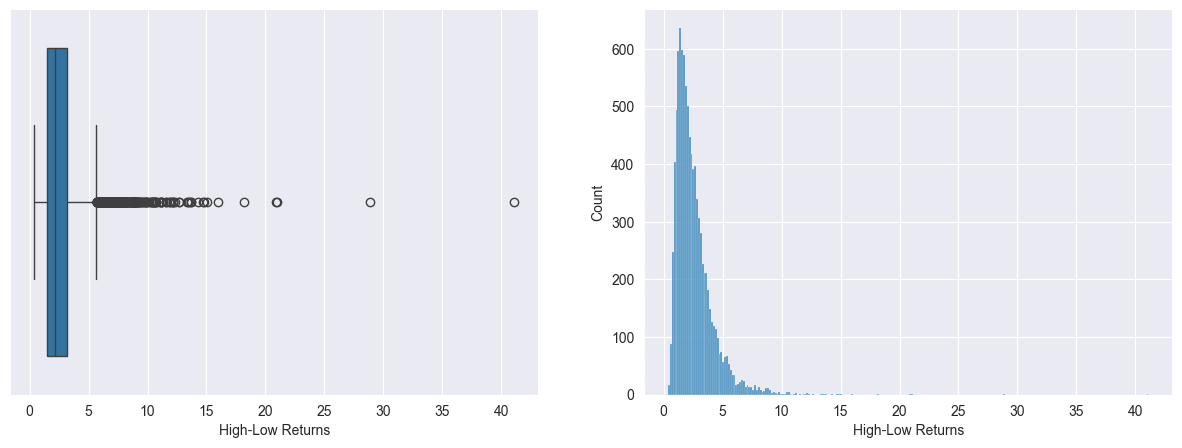

In [345]:
draw_plots(df_microsoft_daily, "High-Low Returns")

In [346]:
show_tab(outliers, df_microsoft_daily['High-Low Returns'])

----------------------------  -----
Kwartyl dolny Q1:              1.46
Kwartyl górny Q3:              3.14
Odstęp międzykwartylowy IQR:   1.69
Lewy wąs:                     -1.07
Prawy wąs:                     5.68
----------------------------  -----


In [347]:
show_tab(outliers_in_percentage,df_microsoft_daily['High-Low Returns'])

-------------------------------  ------
Ilość wartości za lewym wąsem:     0
Ilość wartości za prawym wąsem:  421
Procentowa wartości poza wąsami    4.41
-------------------------------  ------


Naturalnie High-Low Returns moze mieć tylko wartości nieujemne, ponieważ jest to procentowy zwrot między najniższa a najwyższa cena w danym interwale.
Możemy zauważyć że kwartyl dolny Q1 i górny Q3 dla Close-Close Returns wynoszą odpowiednio 1.43% i 3.15%. Wartości odstające stanowią około 4.5% danych w tabeli. 

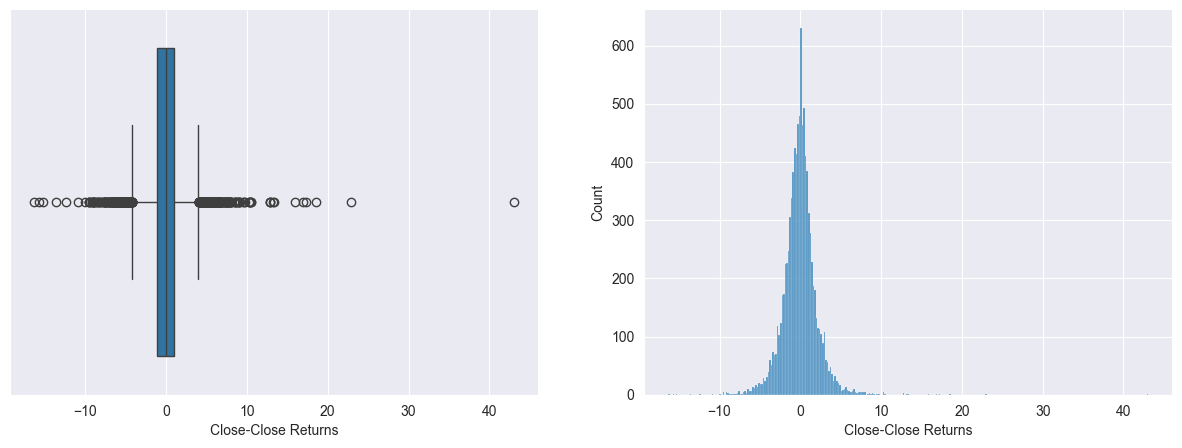

In [348]:
draw_plots(df_microsoft_daily, "Close-Close Returns")

In [349]:
show_tab(outliers,df_microsoft_daily["Close-Close Returns"] )

----------------------------  -----
Kwartyl dolny Q1:             -1.12
Kwartyl górny Q3:              0.93
Odstęp międzykwartylowy IQR:   2.05
Lewy wąs:                     -4.19
Prawy wąs:                     4
----------------------------  -----


In [350]:
show_tab(outliers_in_percentage,df_microsoft_daily["Close-Close Returns"])

-------------------------------  ------
Ilość wartości za lewym wąsem:   249
Ilość wartości za prawym wąsem:  254
Procentowa wartości poza wąsami    5.27
-------------------------------  ------


Możemy zauważyć że kwartyl dolny Q1 i górny Q3 dla Close-Close Returns wynosi odpowiednio -1.12% i 0.93%. Wartości odstające stanowią około 5% danych w tabeli. 

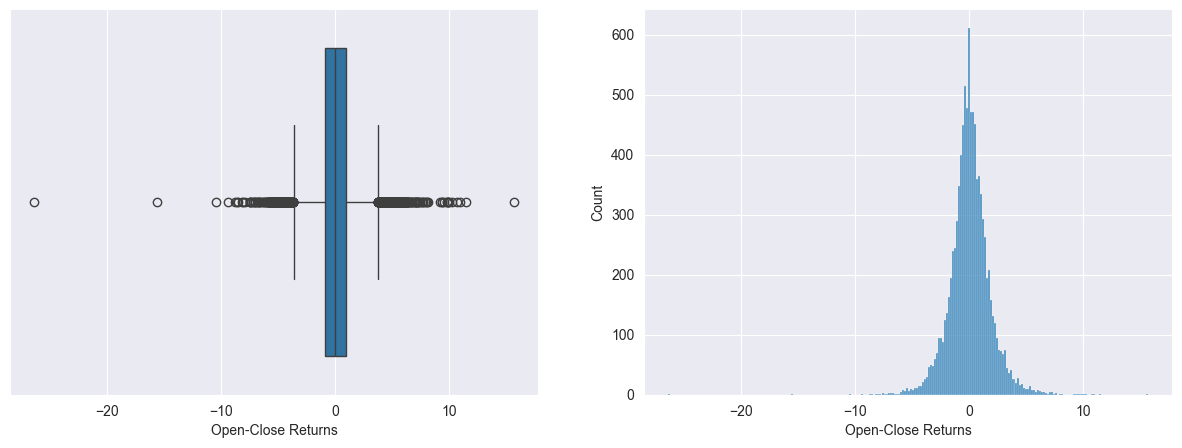

In [351]:
draw_plots(df_microsoft_daily, "Open-Close Returns")

In [352]:
show_tab(outliers,df_microsoft_daily["Open-Close Returns"] )

----------------------------  -----
Kwartyl dolny Q1:             -0.86
Kwartyl górny Q3:              0.99
Odstęp międzykwartylowy IQR:   1.85
Lewy wąs:                     -3.64
Prawy wąs:                     3.76
----------------------------  -----


In [353]:
show_tab(outliers_in_percentage,df_microsoft_daily["Open-Close Returns"])

-------------------------------  ------
Ilość wartości za lewym wąsem:   204
Ilość wartości za prawym wąsem:  256
Procentowa wartości poza wąsami    4.82
-------------------------------  ------


Możemy zauważyć że kwartyl dolny Q1 i górny Q3 dla Close-Close Returns wynosi odpowiednio -0.86% i 0.99%. Wartości odstające stanowią około 5% danych w tabeli. 

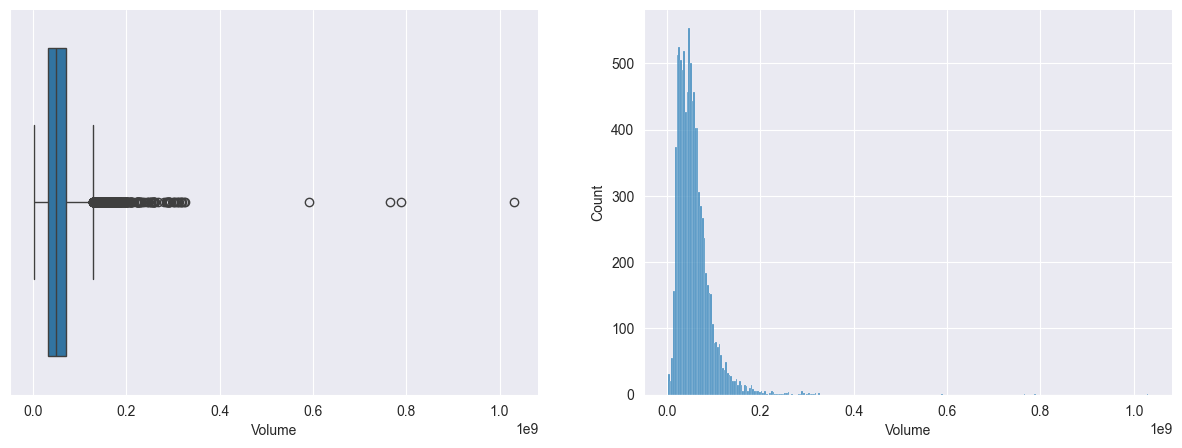

In [354]:
draw_plots(df_microsoft_daily,'Volume')

In [355]:
show_tab(outliers, df_microsoft_daily['Volume'])

----------------------------  ------------
Kwartyl dolny Q1:              3.28155e+07
Kwartyl górny Q3:              7.12002e+07
Odstęp międzykwartylowy IQR:   3.83847e+07
Lewy wąs:                     -2.47616e+07
Prawy wąs:                     1.28777e+08
----------------------------  ------------


In [356]:
show_tab(outliers_in_percentage,df_microsoft_daily['Volume'])

-------------------------------  ------
Ilość wartości za lewym wąsem:     0
Ilość wartości za prawym wąsem:  366
Procentowa wartości poza wąsami    3.84
-------------------------------  ------


Wartości odstające dla każdej z kolumn oscylują wokół 5%. W przypadku analizy finansowej nie chcemy się ich pozbywać, ponieważ moga one mieć istotny wpływ na wynik końcowy analizy.

<h3>Szczegółowa analiza wybranych cech tabel microsoft_daily.db </h3>

Wyznaczanie współczynników
W celu wyznaczenia odpowiednich współczynników, możemy skorzystać z poniższych wzorów.

**Wartość średnia:**
$m = E(X) = \sum p_k * x(k)$

**Wariancja:**
$Var(X) = E((X - m)^2)$

**Moment rzędu k:**
$m_k = E(X^k)$

**Moment centralny rzędu k:**
$\mu_k = E((X-m)^k)$

**Odchylenie strandardowe**
$\sigma = \sqrt{Var(X)}$

**Odchylenie przeciętne**
$d_1 = E|X-m|$

**Kurtoza**
$K = Kurt(X) = \frac{\mu_4}{\sigma_4}$

**Wspołczynnik asymetrii  - skośności**
$A = \gamma_1 = \frac{\mu_3}{\sigma_3}$

**Współczynnik wyostrzenia**
$\gamma_2 = Kurt(X)-3$

Nie będę natomiast korzystał z tych wzorów ponieważ, powyższe współczynniki można obliczyć przez wbudowane metody i funkcjew w bibliotekach numpy i scipy

**Funckje pomocnicze**

Funckja, która pomoże wyznaczyć wskaźniki położenia:

In [357]:
def pos_indicators(values):
    min_ = values.min()
    max_ = values.max()
    Q1 = values.quantile(.25)
    Q3 = values.quantile(.75)

    output = [
        ('Najmniejsza wartość (min)', fun(min_)),
        ('Największa wartość (max)', fun(max_)),
        ('Średnia arytmetyczna', fun(values.mean())),
        ('Kwantyl pierwszy (Q1)', fun(Q1)),
        ('Mediana (Q2)', fun(values.median())),
        ('Kwantyl trzeci (Q3)', fun(Q3)),
    ]
    
    return output

Funkcja, która pozwoli obliczyć wskaźniki rozproszenia:

In [358]:
def scatter_indicators(values):
    std = values.std()
    min_ = values.min()
    max_ = values.max()
    Q1 = values.quantile(.25)
    Q3 = values.quantile(.75)
    IQR = Q3 - Q1
    Q = IQR / 2
    skewness = round(stats.skew(values), 2)
    skew_msg = 'prawostronnie skośny' if skewness > 0 else 'lewostronnie skośny' if skewness < 0 else 'symetryczny'
    excess_kurtosis = stats.kurtosis(values)
    kurtosis = excess_kurtosis + 3
    kurtosis_msg = 'leptokurtyczny' if excess_kurtosis > 0 else 'platykurtyczny' if excess_kurtosis < 0 else 'mezokurtyczny'
    
    return [
        ('Odchylenie standardowe', fun(std)),
        ('Wariancja', fun(std ** 2)),
        ('Rozstęp między skrajnymi wartościami (max - min)', fun(max_ - min_)),
        ('Rozstęp międzykwartylowy (IQR)', fun(IQR)),
        ('Odchylenie ćwiartkowe', fun(Q)),
        ('Współczynnik asymetrii (skośności)', f"{fun(skewness)} ({skew_msg})"),
        ('Kurtoza', fun(kurtosis)),
        ('Współczynnik wyostrzenia', f'{fun(excess_kurtosis)} ({kurtosis_msg})')
    ]

Dodatkowe statystyki:

In [359]:
def additional_statistics(df):
    all_values = df.count()
    positive_values = (df > 0).sum()
    positive_values_probability = positive_values * 100/ all_values
    avg_positive_return = df[df > 0].mean()
    
    negative_values = (df < 0).sum()
    negative_values_probability = negative_values * 100/ all_values
    avg_negative_return = df[df < 0].mean()
    
    zero_values = (df == 0).sum()
    zero_values_probability = zero_values * 100/ all_values
    
    return [
        ('Liczba wartości pozytywnych:', fun(positive_values)),
        ('Liczba wartosci negatywnych:', fun(negative_values)),
        ('Liczba wystepowania zer:', fun(zero_values)),
        ('Procent dodatnich wartości:', fun(positive_values_probability)),
        ('Procent negatywych wartosci:', fun(negative_values_probability)),
        ('Procent wystepowania zer:', fun(zero_values_probability)),
        ('Średni pozytywny zwrot: ', fun(avg_positive_return)),
        ('Średni negatywny zwrot: ', fun(avg_negative_return)),
    ]

In [360]:
def compute_intervals_probability(df, no_bins):
    return df.value_counts(normalize=True, bins=no_bins, sort=False)

In [361]:
def compute_cumulative_intervals_probability(intervals_probability):
    return intervals_probability.cumsum()

In [362]:
def count_frequency_intervals(df, no_bins):
    intervals = pd.cut(df, bins=no_bins, include_lowest=True)

    counter = intervals.value_counts(sort=False)
    return counter

Funkcja, która rysuje wykres kołowy, mówiący o tym jaka część zwrotów jest pozytywna a jaka negatywna.

In [363]:
def plot_pie_chart(df):
    
    positive = (df > 0).sum()
    negative = (df < 0).sum()
    zero = (df == 0).sum()
    plt.figure(figsize=(15,6.5))
    labels = ['Pozytywne', 'Negatywne', 'Zera']
    sizes = [positive, negative, zero]
    colors = ['green', 'red', 'blue']
    
    plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
    plt.title('Rozkład procentowy wartości pozytywnych, negatywnych i zer')
    plt.axis('equal')  
    plt.show()

Funckja, która tworzy wykres przedstawiający rozkład danych.Na wykresie naniesone są także linie pionowe, które informują o tym, w którym miejscu znajdują się mediana i odchylenia standardowe. 

In [364]:
def distribution_chart(df_data, statistic_data, no_bins):
    g = sns.displot(data=df_data, kde=True, bins=no_bins)
    g.fig.set_figwidth(15)
    g.fig.set_figheight(6.5)
    plt.axvline(statistic_data.median(), color='red', linestyle='dashed', linewidth=2, label='Średnia')
    plt.axvline(statistic_data.median(), color='green', linestyle='dashed', linewidth=2, label='Mediana')
    plt.axvline(statistic_data.median() + df_data.std(), color='orange', linestyle='dashed', linewidth=1, label='Średnia + 1SD')
    plt.axvline(statistic_data.median() - df_data.std(), color='orange', linestyle='dashed', linewidth=1, label='Średnia - 1SD')
    plt.axvline(statistic_data.median() + 2*df_data.std(), color='blue', linestyle='dashed', linewidth=1, label='Średnia + 2SD')
    plt.axvline(statistic_data.median() - 2*df_data.std(), color='blue', linestyle='dashed', linewidth=1, label='Średnia - 2SD')
    plt.legend()
    return g

Funkcja tworzy wykres, na którym porównywane są gęstości jądrowe rzeczywistych danych (oznaczonych kolorem niebieskim) i danych symulowanych z rozkładu normalnego (oznaczonych kolorem pomarańczowym)

In [365]:
def compare_with_normal_distribution(real_data):
    mean = real_data.mean()
    std = real_data.std()
    simulated_data = np.random.normal(mean, std, size=1000000)
   
    plt.figure(figsize=(15,6.5)) 
    
    # Rysowanie wykresu
    sns.kdeplot(real_data, label='Real Data', color='blue')
    sns.kdeplot(simulated_data, label='Simulated Data', color='orange')
    

    # Dodawanie tytułów i etykiet osi
    plt.title('Porównanie Rozkładu Normalnego i Rzeczywistych Danych')
    plt.xlabel('Wartości')
    plt.ylabel('Gęstość')
       
    # Dodawanie legendy
    plt.legend()
    plt.show()

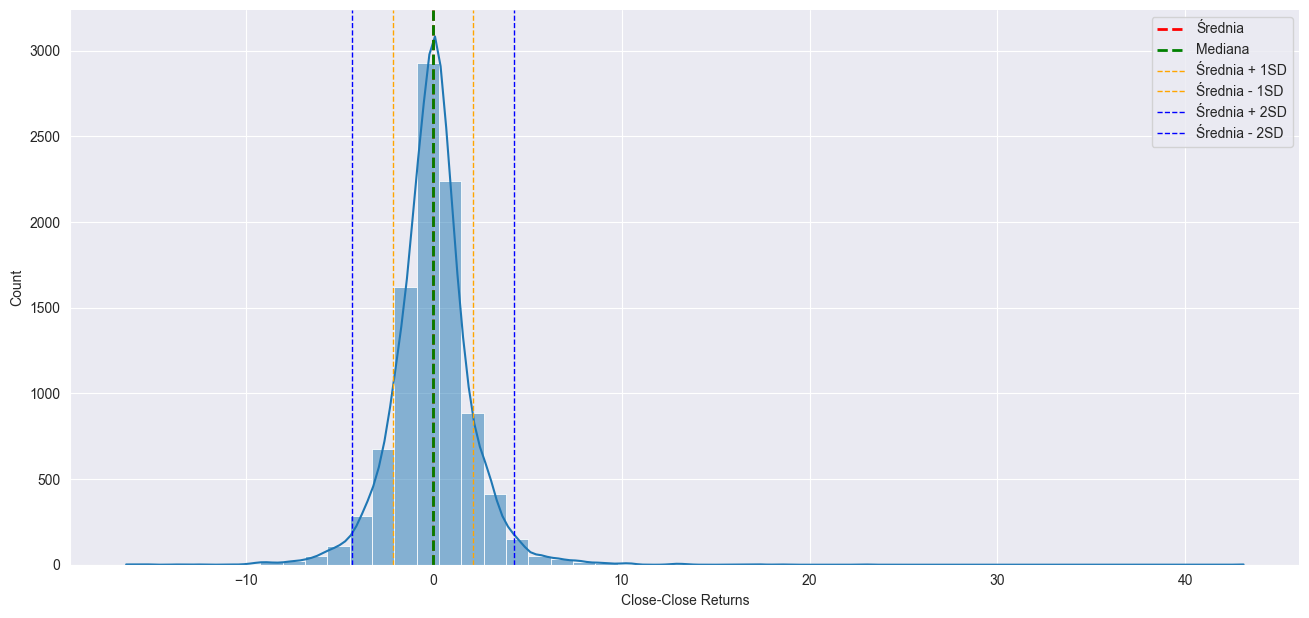

In [366]:
distribution_chart(df_microsoft_daily['Close-Close Returns'],df_microsoft_daily['Close-Close Returns'],50)

Wykres dla wszystkich danych bez filtracji jest mało czytelny. Widać że wartość średnia oscyluje wokół zera.

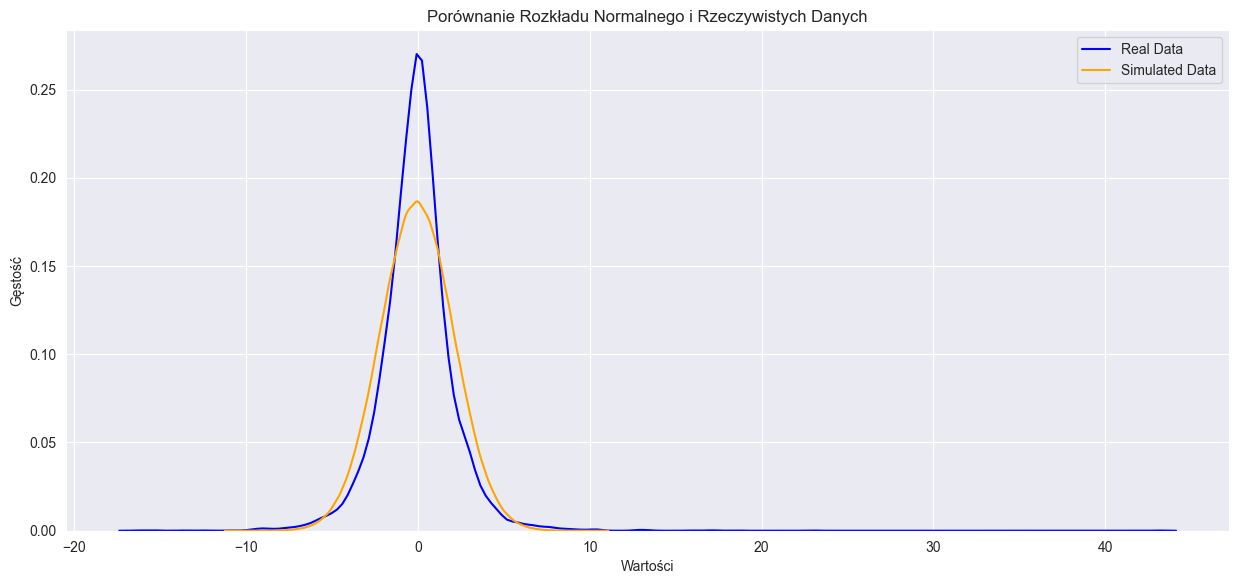

In [367]:
compare_with_normal_distribution(df_microsoft_daily['Close-Close Returns'])

Z powrównania wykresów gęstości rozkładu normalnego i rzeczyswistych danych, możemy stwierdzić,ze kurtoza jest dodatnia, czyli rozkład jest leptokurtyczny.  

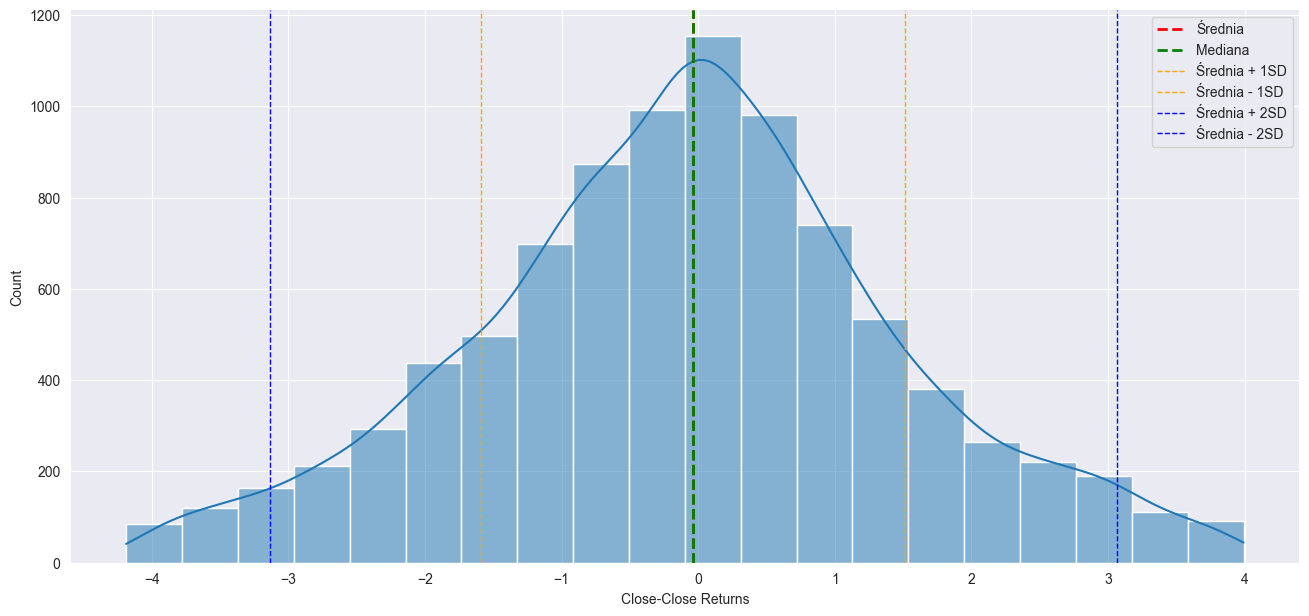

In [368]:
data = df_microsoft_daily['Close-Close Returns']

Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1
left = Q1 - 1.5 * IQR
right = Q3 + 1.5 * IQR

# Wybieramy wartości pomiędzy left i right
selected_values = data[(data >= left) & (data <= right)]
distribution_chart(selected_values, df_microsoft_daily['Close-Close Returns'],20 )

Ten wykres jest już dużo bardziej czytelny za sprawą odfiltorwania wartości odstających, które uniemożliwiały odczytanie wartości z wykresu.

In [369]:
df_microsoft_daily['Close-Close Returns'] = df_microsoft_daily['Close-Close Returns'].fillna(0)

In [370]:
show_tab(pos_indicators,df_microsoft_daily['Close-Close Returns'])

-------------------------  ------
Najmniejsza wartość (min)  -16.36
Największa wartość (max)    43.09
Średnia arytmetyczna        -0.07
Kwantyl pierwszy (Q1)       -1.12
Mediana (Q2)                -0.04
Kwantyl trzeci (Q3)          0.93
-------------------------  ------


In [371]:
show_tab(scatter_indicators, df_microsoft_daily['Close-Close Returns'])

------------------------------------------------  ---------------------------
Odchylenie standardowe                            2.14
Wariancja                                         4.59
Rozstęp między skrajnymi wartościami (max - min)  59.46
Rozstęp międzykwartylowy (IQR)                    2.05
Odchylenie ćwiartkowe                             1.02
Współczynnik asymetrii (skośności)                1.18 (prawostronnie skośny)
Kurtoza                                           26.89
Współczynnik wyostrzenia                          23.89 (leptokurtyczny)
------------------------------------------------  ---------------------------


Szczegółowe obliczenie wskaźników rozproszenia potwierdza nasze prezczucia formułowane na podstawie wyglądu wykresu. Rozkład ma chakarkter mocno leptokurtyczny, bo współczynnik wyostrzenia (względem rozkłądu normalnego) to az 23.88. Rozkłaad jest prawostronnie skośny co oznacza, że 'ogon' znajduje się po prawej stronie wykresu.

In [372]:
intervals_prob = compute_intervals_probability(df_microsoft_daily['Close-Close Returns'],20)
intervals_prob

(-16.424, -13.391]    0.000419
(-13.391, -10.418]    0.000210
(-10.418, -7.445]     0.003039
(-7.445, -4.472]      0.018130
(-4.472, -1.499]      0.169252
(-1.499, 1.474]       0.643157
(1.474, 4.447]        0.146196
(4.447, 7.419]        0.014882
(7.419, 10.392]       0.003354
(10.392, 13.365]      0.000629
(13.365, 16.338]      0.000210
(16.338, 19.311]      0.000314
(19.311, 22.284]      0.000000
(22.284, 25.257]      0.000105
(25.257, 28.23]       0.000000
(28.23, 31.203]       0.000000
(31.203, 34.175]      0.000000
(34.175, 37.148]      0.000000
(37.148, 40.121]      0.000000
(40.121, 43.094]      0.000105
Name: proportion, dtype: float64

Tabela przedstawia prawdopodobieństwo występowania danych w podanych przedziałach. W przedziale od -1.5% do 1.5% znajduje się aż 64% danych.

In [373]:
compute_cumulative_intervals_probability(intervals_prob)

(-16.424, -13.391]    0.000419
(-13.391, -10.418]    0.000629
(-10.418, -7.445]     0.003668
(-7.445, -4.472]      0.021798
(-4.472, -1.499]      0.191050
(-1.499, 1.474]       0.834207
(1.474, 4.447]        0.980402
(4.447, 7.419]        0.995284
(7.419, 10.392]       0.998638
(10.392, 13.365]      0.999266
(13.365, 16.338]      0.999476
(16.338, 19.311]      0.999790
(19.311, 22.284]      0.999790
(22.284, 25.257]      0.999895
(25.257, 28.23]       0.999895
(28.23, 31.203]       0.999895
(31.203, 34.175]      0.999895
(34.175, 37.148]      0.999895
(37.148, 40.121]      0.999895
(40.121, 43.094]      1.000000
Name: proportion, dtype: float64

Tabela przedstawia skumulowane pradopodobieństwo dla przedziałow. Prawdopodobieństwo skumulowane gwałtownie rośnie dla przedziału -1.5%, 1,5%.

Dystrybuantę tworzę za pomocą funckji:

In [374]:
# Rysujemy dystrybuantę
def distribuant(data):
    plt.figure(figsize=(15,6.5)) 
    sns.ecdfplot(data)
    # Dodajemy tytuł i opis osi
    plt.title('Dystrybuanta')
    plt.xlabel('Procentowe wartosci zwrotów')
    plt.ylabel('Prawdopodobieństwo kumulatywne')
    plt.show()

Dystrybuanta empiryczna:

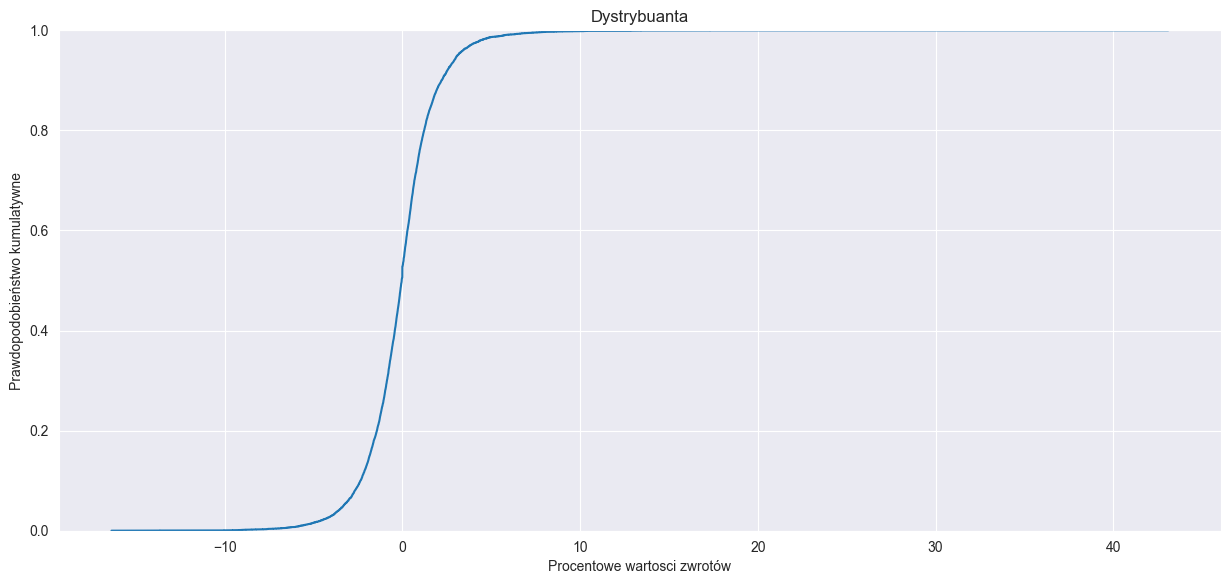

In [375]:
distribuant(df_microsoft_daily['Close-Close Returns'])

In [376]:
count_frequency_intervals(df_microsoft_daily['Close-Close Returns'],20)

Close-Close Returns
(-16.424, -13.391]       4
(-13.391, -10.418]       2
(-10.418, -7.445]       29
(-7.445, -4.472]       173
(-4.472, -1.499]      1615
(-1.499, 1.474]       6137
(1.474, 4.447]        1395
(4.447, 7.419]         142
(7.419, 10.392]         32
(10.392, 13.365]         6
(13.365, 16.338]         2
(16.338, 19.311]         3
(19.311, 22.284]         0
(22.284, 25.257]         1
(25.257, 28.23]          0
(28.23, 31.203]          0
(31.203, 34.175]         0
(34.175, 37.148]         0
(37.148, 40.121]         0
(40.121, 43.094]         1
Name: count, dtype: int64

Tabela przedstawia ilość wystąpień zmiennej loswowej w danych przedziałach.

In [377]:
show_tab(additional_statistics,df_microsoft_daily['Close-Close Returns'])

----------------------------  -------
Liczba wartości pozytywnych:  4501
Liczba wartosci negatywnych:  4829
Liczba wystepowania zer:       212
Procent dodatnich wartości:     47.17
Procent negatywych wartosci:    50.61
Procent wystepowania zer:        2.22
Średni pozytywny zwrot:          1.47
Średni negatywny zwrot:         -1.51
----------------------------  -------


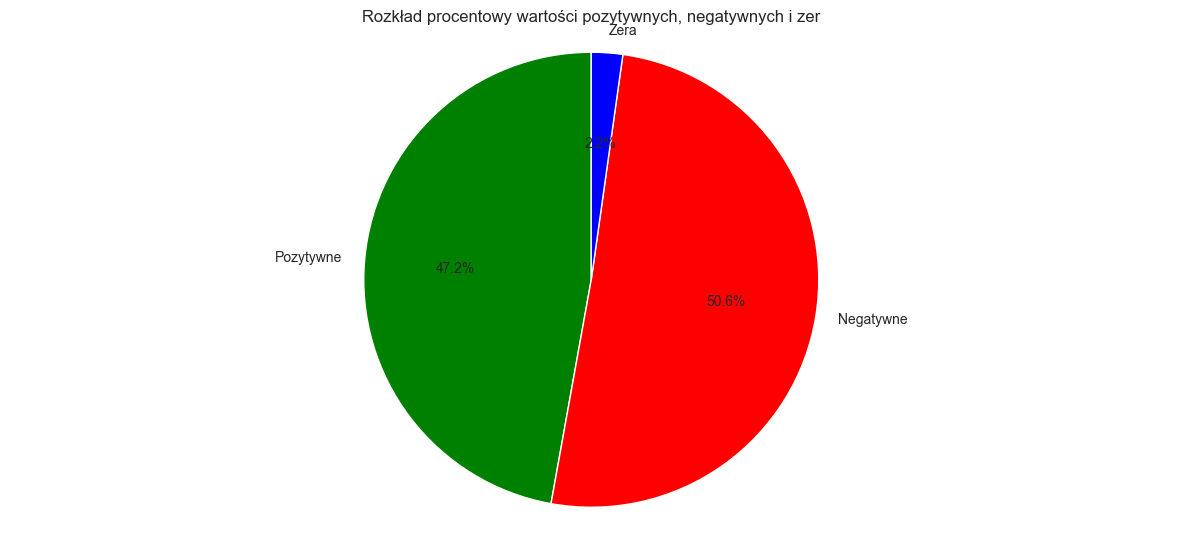

In [378]:
plot_pie_chart(df_microsoft_daily['Close-Close Returns'])

<h3>Analiza wartości odstających dla microsoft_weekly.db </h3>

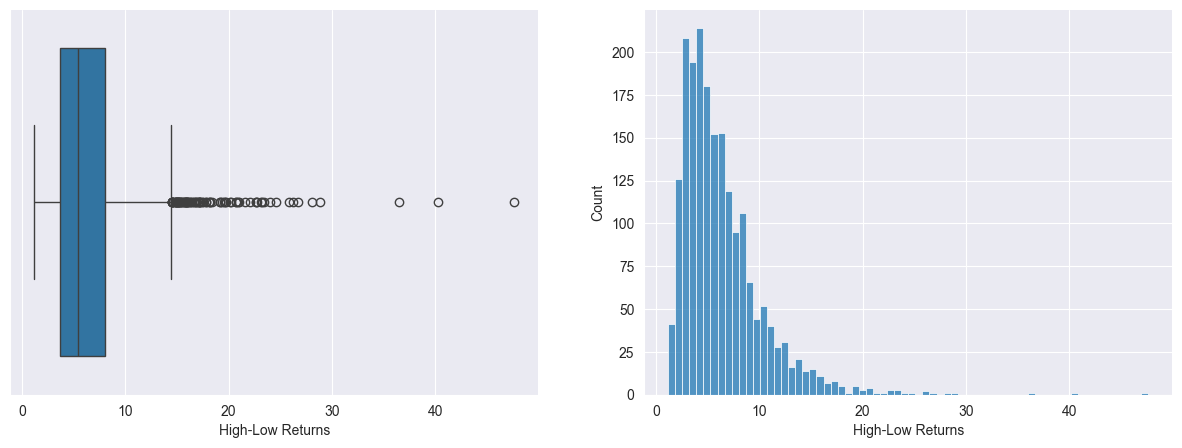

In [379]:
draw_plots(df_microsoft_weekly, "High-Low Returns")

In [380]:
show_tab(outliers, df_microsoft_weekly['High-Low Returns'])

----------------------------  -----
Kwartyl dolny Q1:              3.67
Kwartyl górny Q3:              8.01
Odstęp międzykwartylowy IQR:   4.33
Lewy wąs:                     -2.83
Prawy wąs:                    14.51
----------------------------  -----


In [381]:
show_tab(outliers_in_percentage,df_microsoft_weekly['High-Low Returns'])

-------------------------------  ----
Ilość wartości za lewym wąsem:    0
Ilość wartości za prawym wąsem:  85
Procentowa wartości poza wąsami   4.3
-------------------------------  ----


Kwartyl dolny i kwartyl dolny wynoszą odpowiednio 3.68% i 8.01% Bez zaskoczenia dla interwału tygodniowego zmienność jest dużo większa niż dla interwału 1dniowego. Około 4% wartości leży poza lewym lub prawym wąsem.

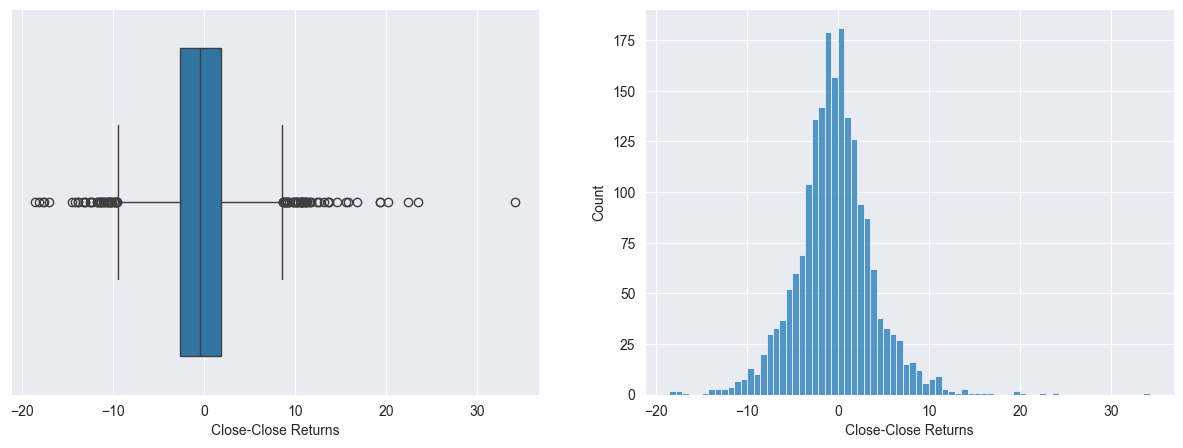

In [382]:
draw_plots(df_microsoft_weekly, "Close-Close Returns")

In [383]:
show_tab(outliers, df_microsoft_weekly['Close-Close Returns'])

----------------------------  -----
Kwartyl dolny Q1:             -2.69
Kwartyl górny Q3:              1.85
Odstęp międzykwartylowy IQR:   4.53
Lewy wąs:                     -9.49
Prawy wąs:                     8.65
----------------------------  -----


In [384]:
show_tab(outliers_in_percentage,df_microsoft_weekly['Close-Close Returns'])

-------------------------------  -----
Ilość wartości za lewym wąsem:   41
Ilość wartości za prawym wąsem:  52
Procentowa wartości poza wąsami   4.71
-------------------------------  -----


Poza wąsami leży podobnie jak w interwale 1dniowym około 5% wartości, natomiast zmienność rośnie dużo wolniej. Kwartyl dolny Q1 i kwartylgórny Q3 wynoszą odpowiednio -2.69% i 1.85% co nie odbiega bardzo od interwału 1dniowego gdzie oberwowaliśmy około +-1.5%. 

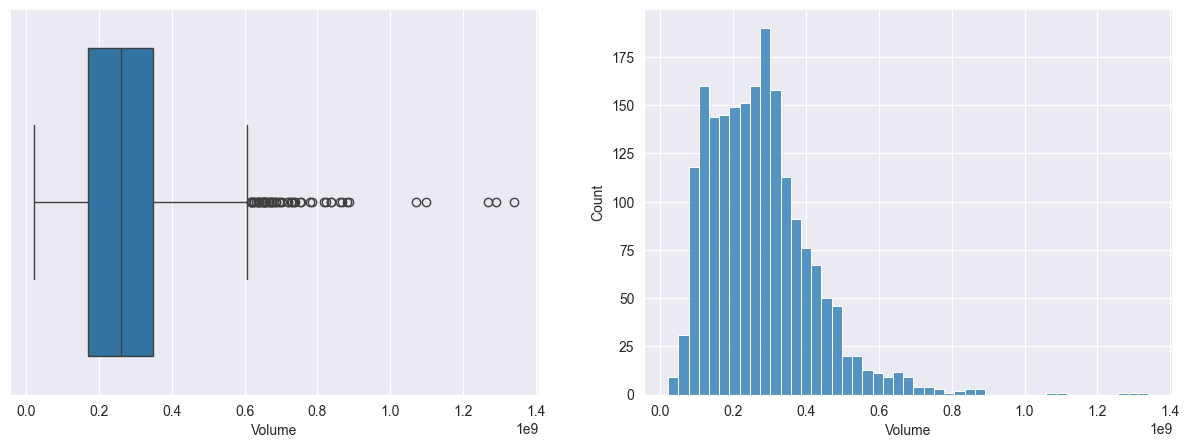

In [385]:
draw_plots(df_microsoft_weekly,'Volume')

In [386]:
show_tab(outliers, df_microsoft_weekly['Volume'])

----------------------------  ------------
Kwartyl dolny Q1:              1.70038e+08
Kwartyl górny Q3:              3.4836e+08
Odstęp międzykwartylowy IQR:   1.78322e+08
Lewy wąs:                     -9.7445e+07
Prawy wąs:                     6.15843e+08
----------------------------  ------------


In [387]:
show_tab(outliers_in_percentage,df_microsoft_weekly['Volume'])

-------------------------------  -----
Ilość wartości za lewym wąsem:    0
Ilość wartości za prawym wąsem:  55
Procentowa wartości poza wąsami   2.78
-------------------------------  -----


<h3>Analiza szczegółowa microsoft_weekly.db</h3>

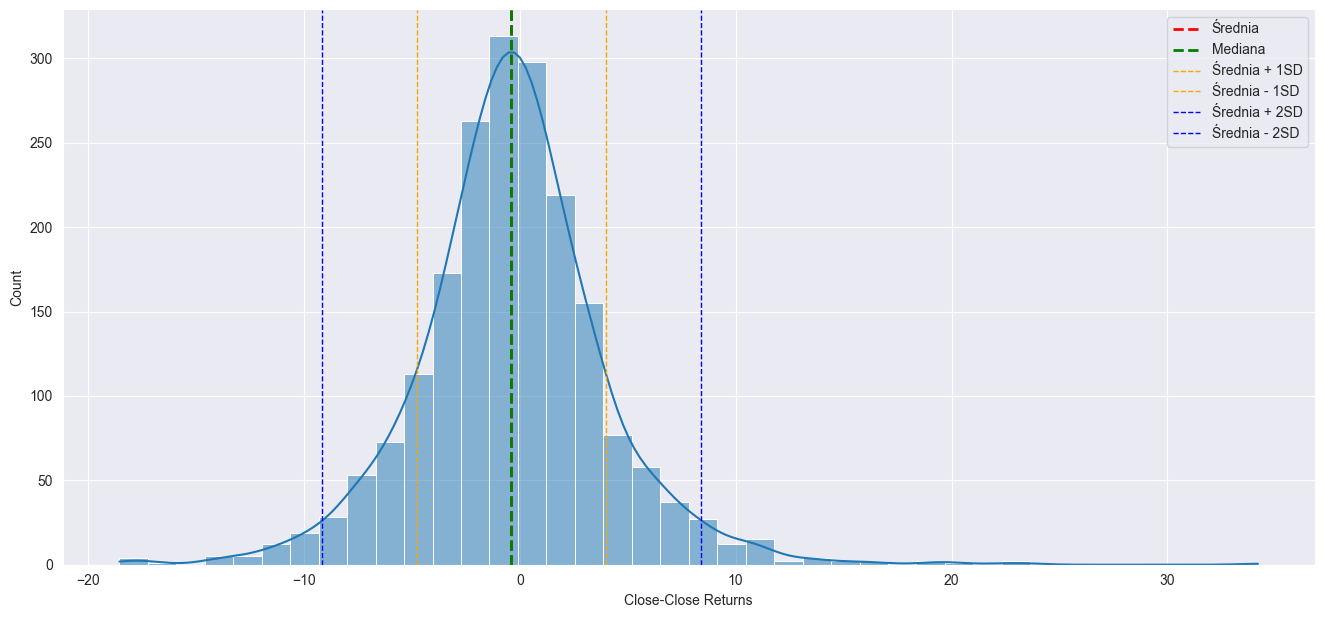

In [388]:
distribution_chart(df_microsoft_weekly['Close-Close Returns'],df_microsoft_weekly['Close-Close Returns'],40)

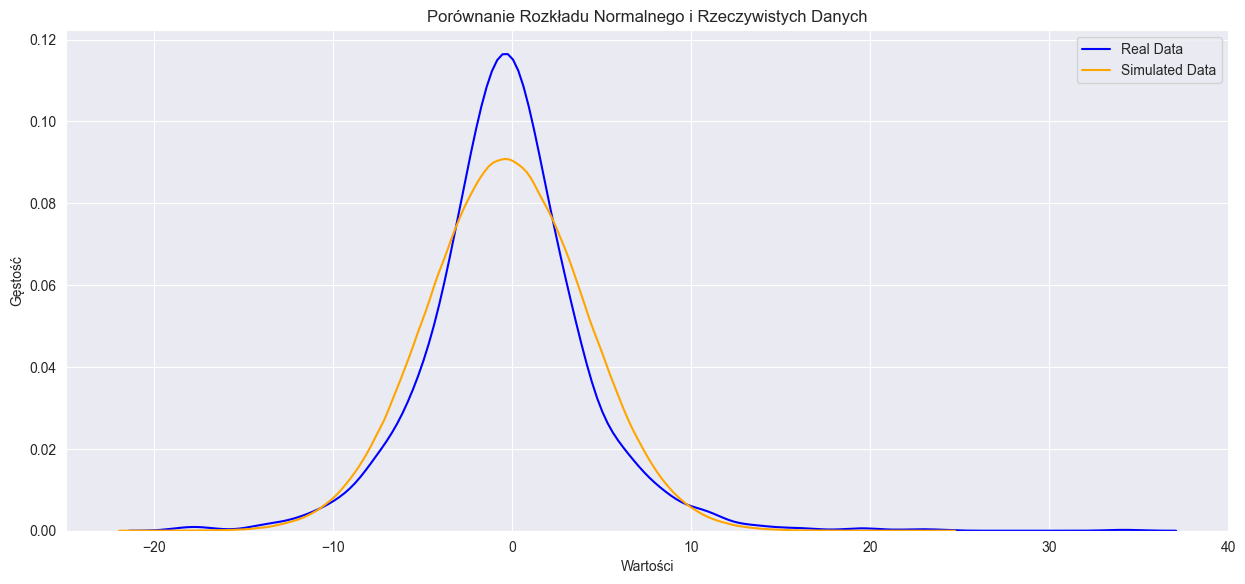

In [389]:
compare_with_normal_distribution(df_microsoft_weekly['Close-Close Returns'])

Wizualnie wydaje się, że współczynnik wyostrzenia jest mniejszy dla interwału tygodniowego niż dla inetrwału 1dniowego.

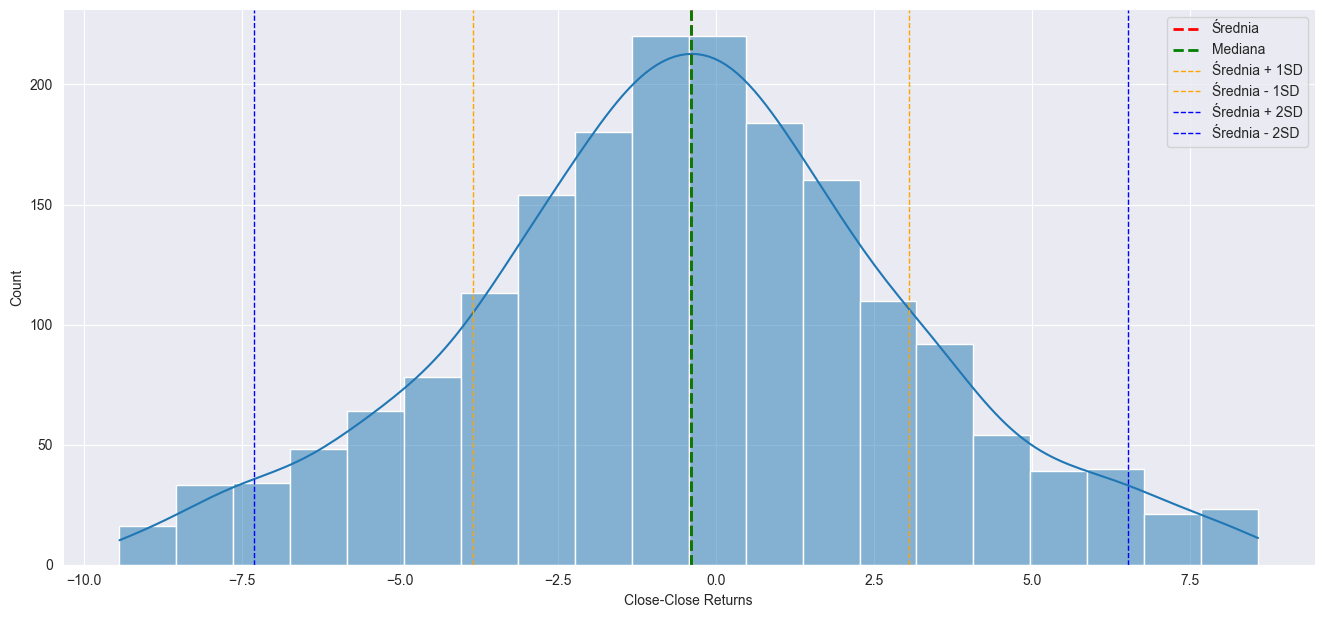

In [390]:
data = df_microsoft_weekly['Close-Close Returns']

Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1
left = Q1 - 1.5 * IQR
right = Q3 + 1.5 * IQR

# Wybieramy wartości pomiędzy left a right
selected_values = data[(data >= left) & (data <= right)]
distribution_chart(selected_values, df_microsoft_weekly['Close-Close Returns'],20 )

Wykres dystrybucji po odfiltrowaniu wartości odstających.

In [391]:
df_microsoft_weekly['Close-Close Returns'] = df_microsoft_weekly['Close-Close Returns'].fillna(0)

In [392]:
show_tab(pos_indicators,df_microsoft_weekly['Close-Close Returns'])

-------------------------  ------
Najmniejsza wartość (min)  -18.55
Największa wartość (max)    34.2
Średnia arytmetyczna        -0.35
Kwantyl pierwszy (Q1)       -2.68
Mediana (Q2)                -0.39
Kwantyl trzeci (Q3)          1.84
-------------------------  ------


In [393]:
show_tab(scatter_indicators, df_microsoft_weekly['Close-Close Returns'])

------------------------------------------------  ---------------------------
Odchylenie standardowe                            4.38
Wariancja                                         19.23
Rozstęp między skrajnymi wartościami (max - min)  52.74
Rozstęp międzykwartylowy (IQR)                    4.53
Odchylenie ćwiartkowe                             2.26
Współczynnik asymetrii (skośności)                0.48 (prawostronnie skośny)
Kurtoza                                           7.20
Współczynnik wyostrzenia                          4.20 (leptokurtyczny)
------------------------------------------------  ---------------------------


Interwał tygodniowy ma kurtozę bardziej znormalizowaną - jest mniej wyostrzona, tak jak założyłem na podstawie obserwacji wykresu, co nie zmienia faktu, że rozkład dalej ma charakter leptokurtyczny i tak samo jak dla interwału 1dniowego rozkłąd jest prawostronnie skośny, czyli ma ogon po prawej stronie wykresu.

In [394]:
intervals_prob = compute_intervals_probability(df_microsoft_weekly['Close-Close Returns'],15)
intervals_prob

(-18.6, -15.03]      0.002529
(-15.03, -11.514]    0.006576
(-11.514, -7.998]    0.028326
(-7.998, -4.482]     0.099140
(-4.482, -0.965]     0.294891
(-0.965, 2.551]      0.367729
(2.551, 6.067]       0.136065
(6.067, 9.583]       0.044512
(9.583, 13.1]        0.013151
(13.1, 16.616]       0.003541
(16.616, 20.132]     0.001517
(20.132, 23.648]     0.001517
(23.648, 27.165]     0.000000
(27.165, 30.681]     0.000000
(30.681, 34.197]     0.000506
Name: proportion, dtype: float64

Tabela przedstawiwa prawdopodobieństwo wystepowania zmiennej losowej dla danych przedziałwo. W przedziale -4.5% do 2.5%, leży aż 65% danych.

In [395]:
compute_cumulative_intervals_probability(intervals_prob)

(-18.6, -15.03]      0.002529
(-15.03, -11.514]    0.009105
(-11.514, -7.998]    0.037430
(-7.998, -4.482]     0.136571
(-4.482, -0.965]     0.431462
(-0.965, 2.551]      0.799191
(2.551, 6.067]       0.935255
(6.067, 9.583]       0.979767
(9.583, 13.1]        0.992919
(13.1, 16.616]       0.996459
(16.616, 20.132]     0.997977
(20.132, 23.648]     0.999494
(23.648, 27.165]     0.999494
(27.165, 30.681]     0.999494
(30.681, 34.197]     1.000000
Name: proportion, dtype: float64

Dystrybuanta empiryczna:

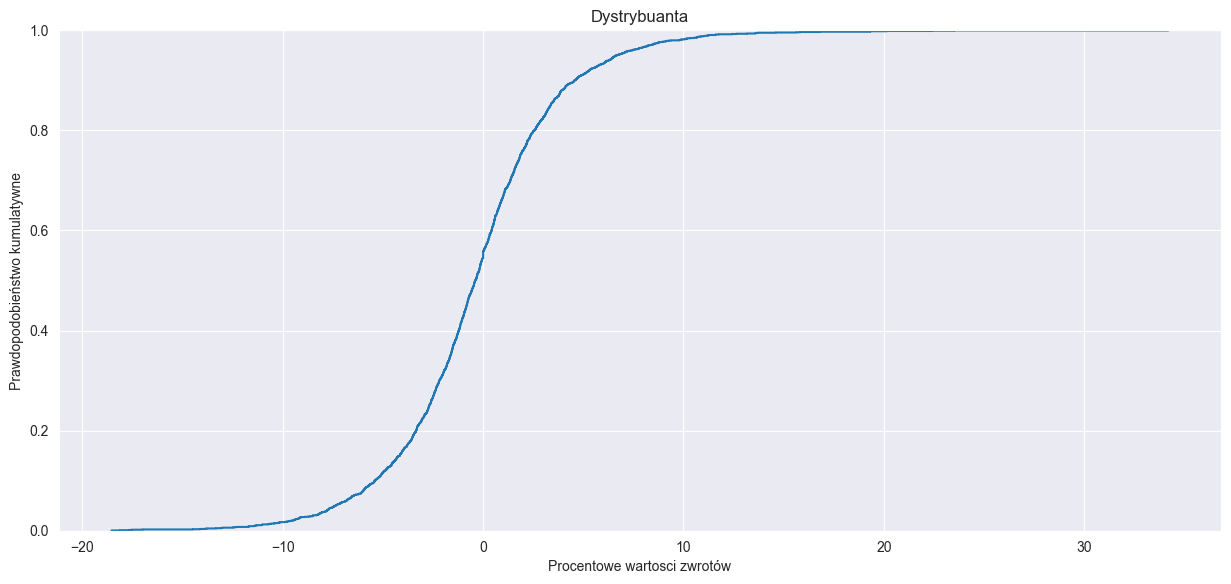

In [396]:
distribuant(df_microsoft_weekly['Close-Close Returns'])

Dystrybuanta jest mniej wyostrzona niż to było w przypadku interwału 1dniowego - prawdopodobieństwo kumulatywne rośnie wolniej.

In [397]:
show_tab(additional_statistics,df_microsoft_weekly['Close-Close Returns'])

----------------------------  -------
Liczba wartości pozytywnych:   874
Liczba wartosci negatywnych:  1077
Liczba wystepowania zer:        26
Procent dodatnich wartości:     44.21
Procent negatywych wartosci:    54.48
Procent wystepowania zer:        1.32
Średni pozytywny zwrot:          3.19
Średni negatywny zwrot:         -3.23
----------------------------  -------


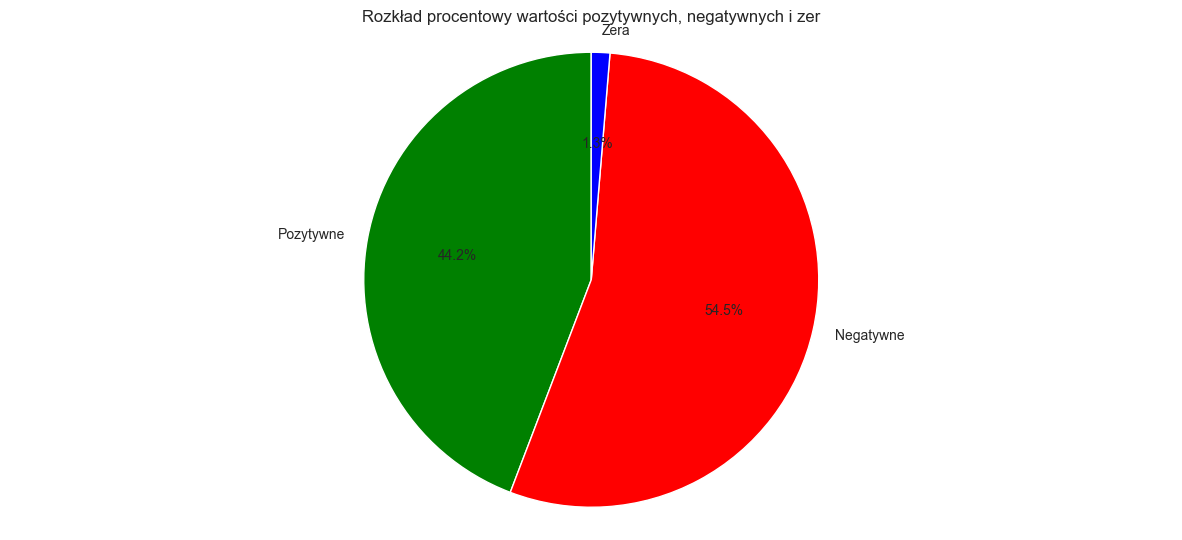

In [398]:
plot_pie_chart(df_microsoft_weekly['Close-Close Returns'])

Warto zauważyć, że dla interwału tygodnioewgo zwiększyła się ilość negatywnych zwrotów i wynosi ona około 55% wszystkich zmiennych losowych.

<h3>analiza wartości odstajacych microsoft_monthly.db </h3>

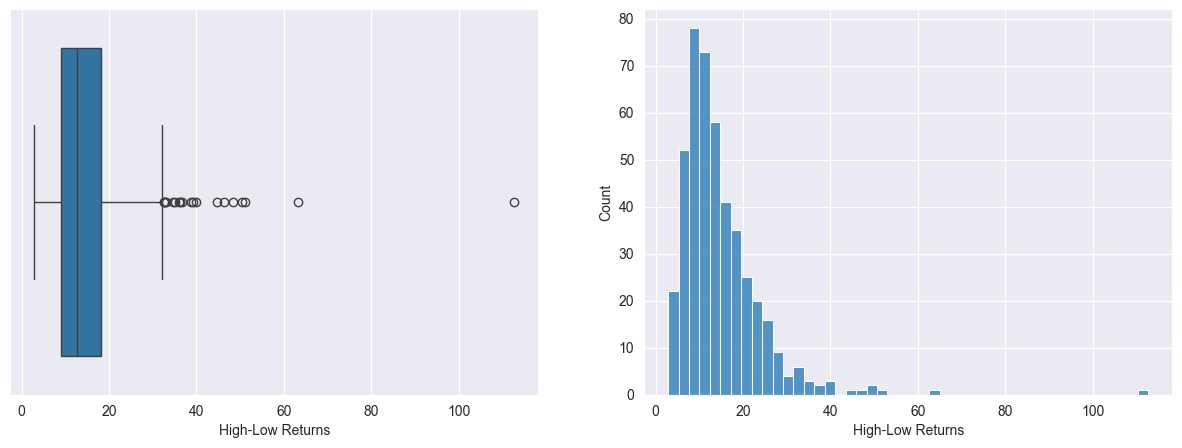

In [399]:
draw_plots(df_microsoft_monthly, "High-Low Returns")

In [400]:
show_tab(outliers, df_microsoft_monthly['High-Low Returns'])

----------------------------  -----
Kwartyl dolny Q1:              8.95
Kwartyl górny Q3:             18.28
Odstęp międzykwartylowy IQR:   9.33
Lewy wąs:                     -5.04
Prawy wąs:                    32.27
----------------------------  -----


In [401]:
show_tab(outliers_in_percentage,df_microsoft_monthly['High-Low Returns'])

-------------------------------  -----
Ilość wartości za lewym wąsem:    0
Ilość wartości za prawym wąsem:  19
Procentowa wartości poza wąsami   4.19
-------------------------------  -----


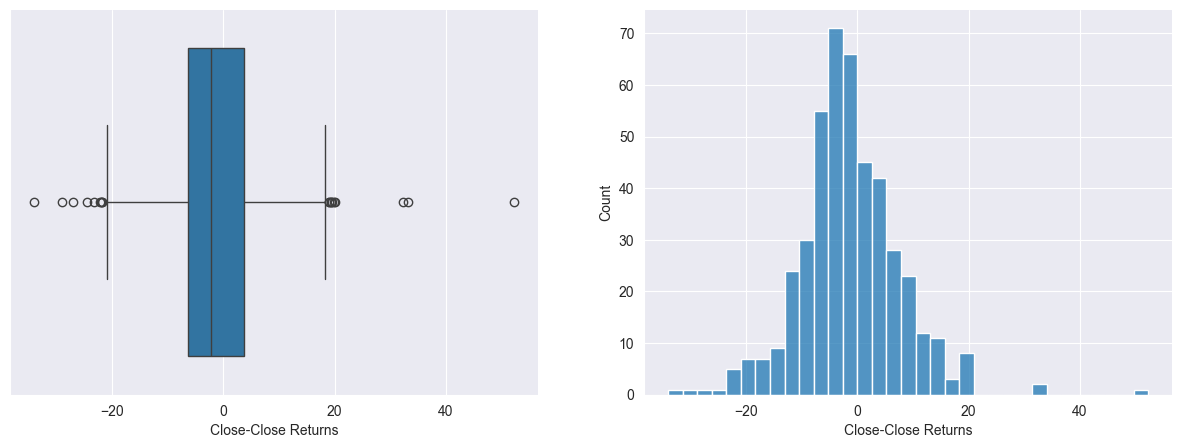

In [402]:
draw_plots(df_microsoft_monthly, "Close-Close Returns")

In [403]:
show_tab(outliers, df_microsoft_monthly['Close-Close Returns'])

----------------------------  ------
Kwartyl dolny Q1:              -6.38
Kwartyl górny Q3:               3.7
Odstęp międzykwartylowy IQR:   10.08
Lewy wąs:                     -21.5
Prawy wąs:                     18.83
----------------------------  ------


In [404]:
show_tab(outliers_in_percentage,df_microsoft_monthly['Close-Close Returns'])

-------------------------------  -----
Ilość wartości za lewym wąsem:    9
Ilość wartości za prawym wąsem:  10
Procentowa wartości poza wąsami   4.19
-------------------------------  -----


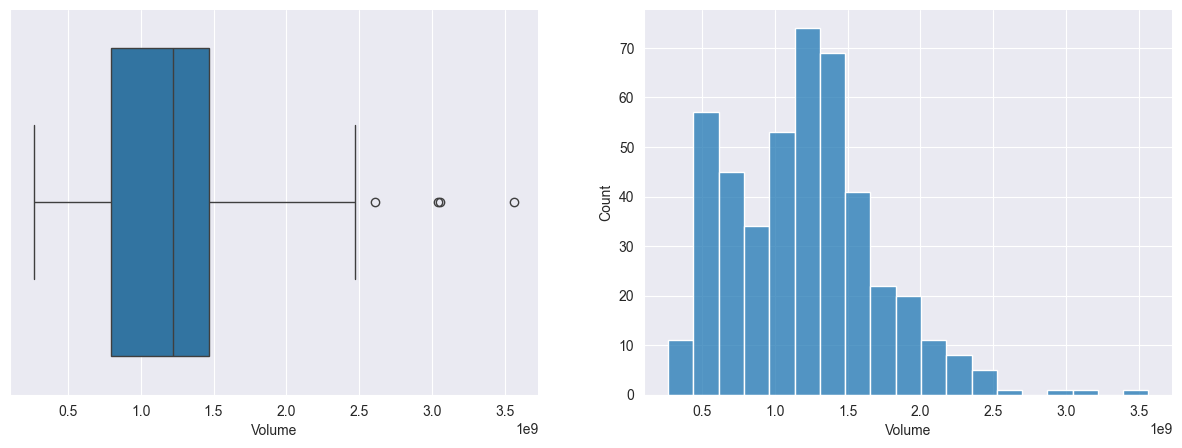

In [405]:
draw_plots(df_microsoft_monthly, "Volume")

In [406]:
show_tab(outliers, df_microsoft_monthly['Volume'])

----------------------------  ------------
Kwartyl dolny Q1:              7.94724e+08
Kwartyl górny Q3:              1.47162e+09
Odstęp międzykwartylowy IQR:   6.76898e+08
Lewy wąs:                     -2.20623e+08
Prawy wąs:                     2.48697e+09
----------------------------  ------------


In [407]:
show_tab(outliers_in_percentage, df_microsoft_monthly['Volume'])

-------------------------------  ----
Ilość wartości za lewym wąsem:   0
Ilość wartości za prawym wąsem:  4
Procentowa wartości poza wąsami  0.88
-------------------------------  ----


<h3>Szczegółowa analiza wybranych cech tabeli microsoft_monthly.db</h3>

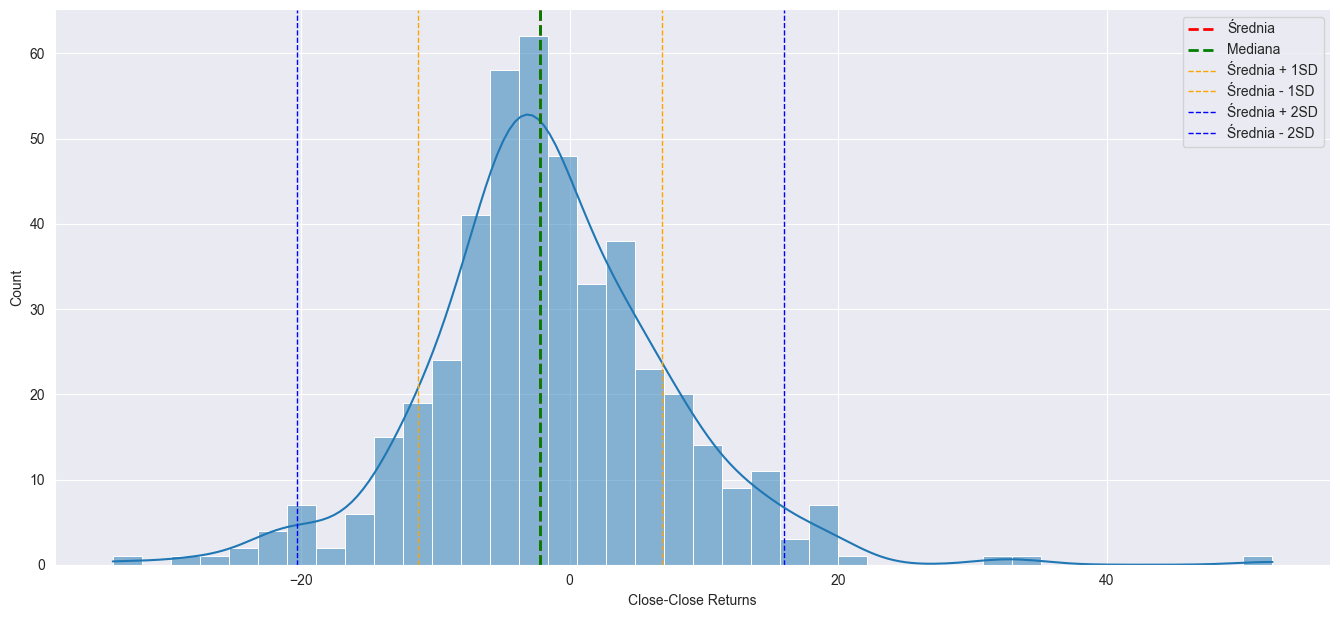

In [408]:
distribution_chart(df_microsoft_monthly['Close-Close Returns'],df_microsoft_monthly['Close-Close Returns'],40)

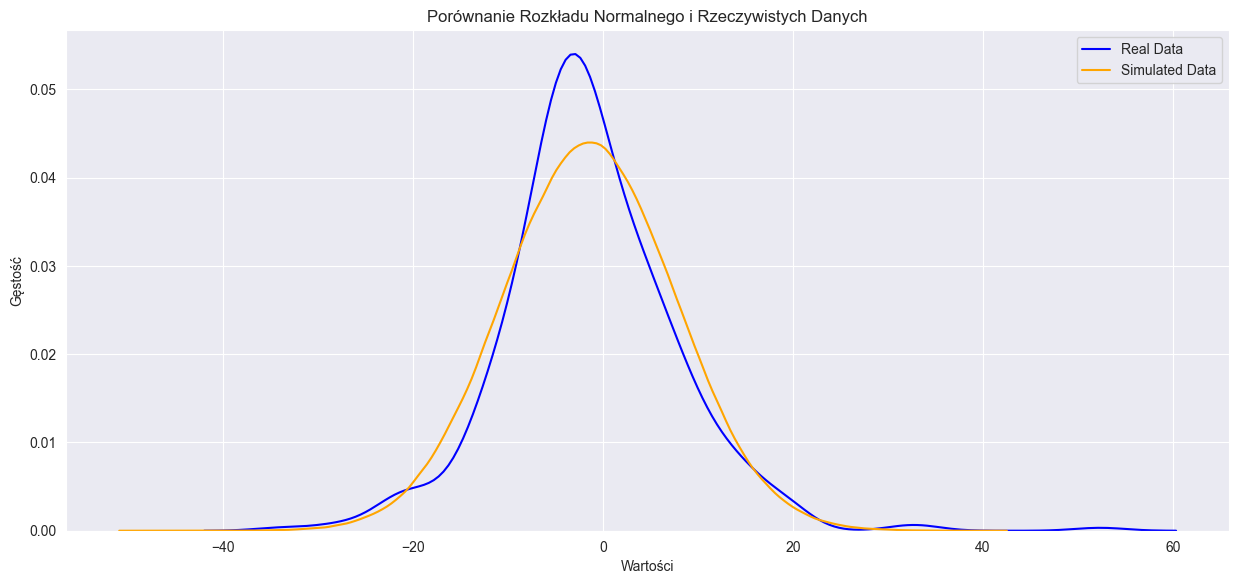

In [409]:
compare_with_normal_distribution(df_microsoft_monthly['Close-Close Returns'])

Wizualnie możemy stwierdzić, że rozkład zmiennej jest 'przesuniety w lewo' względem wygenerowanego rozkładu normalnego.

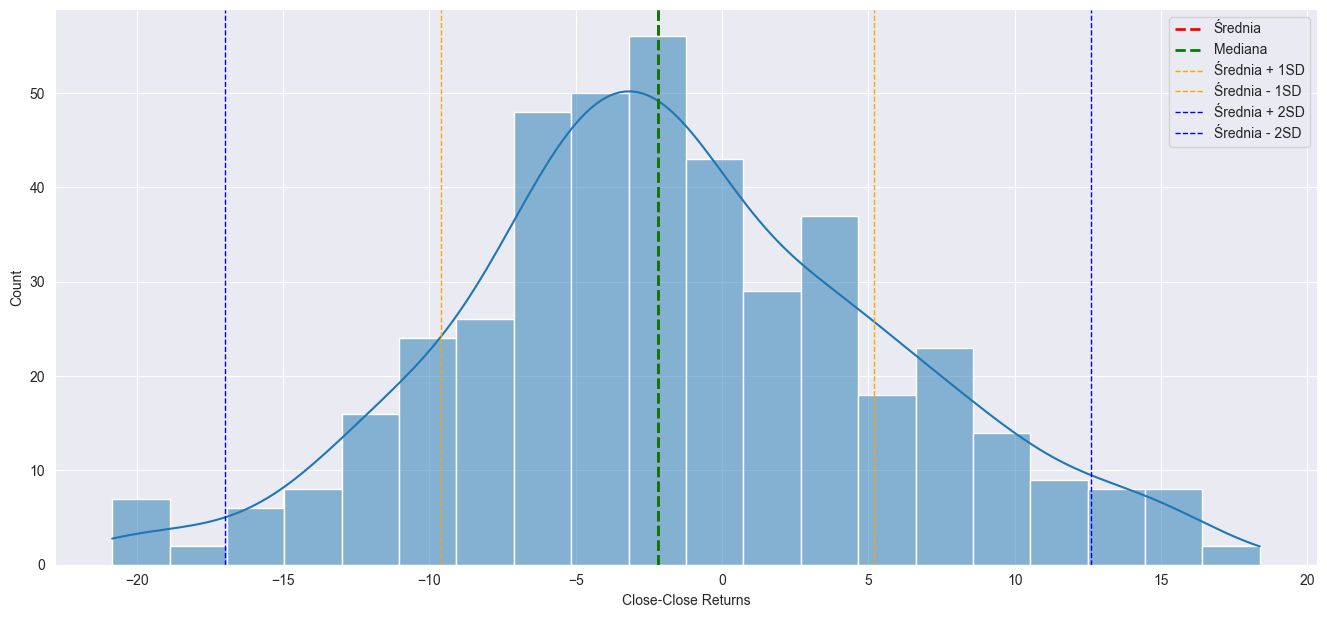

In [410]:
data = df_microsoft_monthly['Close-Close Returns']

Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1
left = Q1 - 1.5 * IQR
right = Q3 + 1.5 * IQR

# Wybieramy wartości pomiędzy left a right
selected_values = data[(data >= left) & (data <= right)]
distribution_chart(selected_values, df_microsoft_monthly['Close-Close Returns'],20 )

Rozkład dystrybucji z odfiltrowanymi wartościami odstającymi.

In [411]:
df_microsoft_monthly['Close-Close Returns'] = df_microsoft_monthly['Close-Close Returns'].fillna(0)

In [412]:
show_tab(pos_indicators,df_microsoft_monthly['Close-Close Returns'])

-------------------------  ------
Najmniejsza wartość (min)  -34.02
Największa wartość (max)    52.33
Średnia arytmetyczna        -1.48
Kwantyl pierwszy (Q1)       -6.37
Mediana (Q2)                -2.18
Kwantyl trzeci (Q3)          3.7
-------------------------  ------


In [413]:
show_tab(scatter_indicators, df_microsoft_monthly['Close-Close Returns'])

------------------------------------------------  ---------------------------
Odchylenie standardowe                            9.06
Wariancja                                         82.01
Rozstęp między skrajnymi wartościami (max - min)  86.35
Rozstęp międzykwartylowy (IQR)                    10.06
Odchylenie ćwiartkowe                             5.03
Współczynnik asymetrii (skośności)                0.54 (prawostronnie skośny)
Kurtoza                                           6.46
Współczynnik wyostrzenia                          3.46 (leptokurtyczny)
------------------------------------------------  ---------------------------


Rozkład dalej ma charakter lepotkurtyczny i jest prawostronnie skońny. To co jest warte zauważenia to, ze dla interwału miesięcznego mediana i wartość średnia, są ujemne i wynoszą odpowiednio -2.18% i -1.47%. Dla niższych interwałów te wartości oscylowały w granichac zera.

In [414]:
intervals_prob = compute_intervals_probability(df_microsoft_monthly['Close-Close Returns'],15)
intervals_prob

(-34.104, -28.26]     0.004405
(-28.26, -22.504]     0.006608
(-22.504, -16.748]    0.028634
(-16.748, -10.991]    0.066079
(-10.991, -5.235]     0.204846
(-5.235, 0.522]       0.332599
(0.522, 6.278]        0.187225
(6.278, 12.035]       0.105727
(12.035, 17.791]      0.039648
(17.791, 23.548]      0.017621
(23.548, 29.304]      0.000000
(29.304, 35.06]       0.004405
(35.06, 40.817]       0.000000
(40.817, 46.573]      0.000000
(46.573, 52.33]       0.002203
Name: proportion, dtype: float64

Tabela przedstawia prawdopodobieństwo wystąpienia zmiennej losowej w danym przedziale. Co warte odnotowania ponad połowa wszystkich wartości najduje się pomiedzy -11% a 0.5%

In [415]:
compute_cumulative_intervals_probability(intervals_prob)

(-34.104, -28.26]     0.004405
(-28.26, -22.504]     0.011013
(-22.504, -16.748]    0.039648
(-16.748, -10.991]    0.105727
(-10.991, -5.235]     0.310573
(-5.235, 0.522]       0.643172
(0.522, 6.278]        0.830396
(6.278, 12.035]       0.936123
(12.035, 17.791]      0.975771
(17.791, 23.548]      0.993392
(23.548, 29.304]      0.993392
(29.304, 35.06]       0.997797
(35.06, 40.817]       0.997797
(40.817, 46.573]      0.997797
(46.573, 52.33]       1.000000
Name: proportion, dtype: float64

Tabela przedstawia prawdopodobieństwo kumulatywne dla danych przdziałow

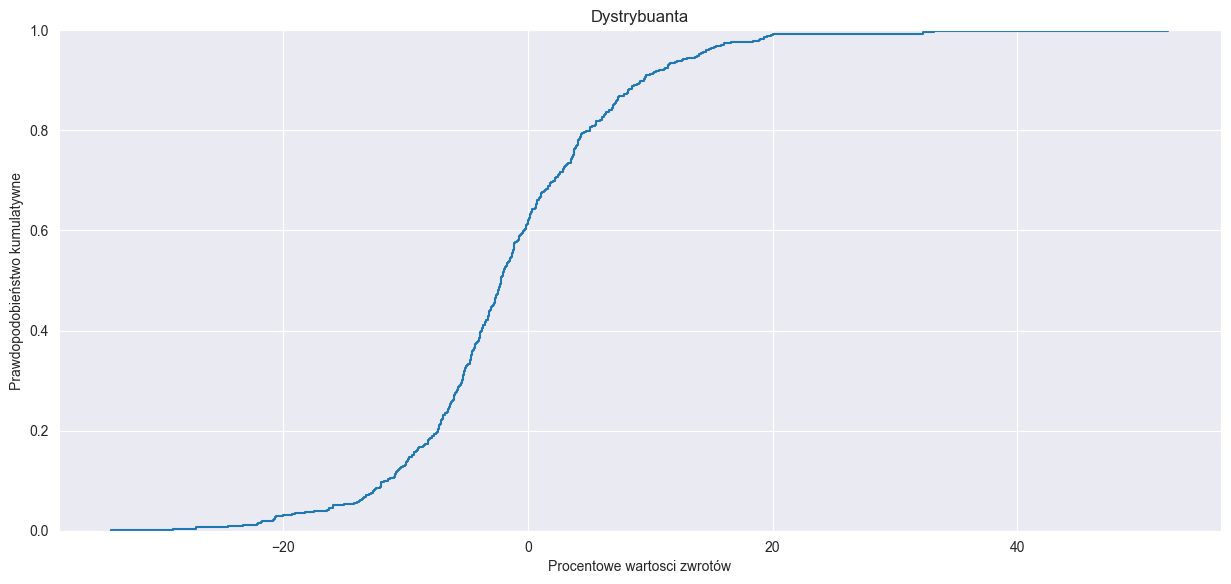

In [416]:
distribuant(df_microsoft_monthly['Close-Close Returns'])

In [417]:
count_frequency_intervals(df_microsoft_monthly['Close-Close Returns'],20)

Close-Close Returns
(-34.104, -29.7]        1
(-29.7, -25.382]        2
(-25.382, -21.065]      6
(-21.065, -16.748]      9
(-16.748, -12.43]      21
(-12.43, -8.113]       43
(-8.113, -3.796]       99
(-3.796, 0.522]       111
(0.522, 4.839]         71
(4.839, 9.156]         43
(9.156, 13.474]        23
(13.474, 17.791]       14
(17.791, 22.108]        8
(22.108, 26.426]        0
(26.426, 30.743]        0
(30.743, 35.06]         2
(35.06, 39.378]         0
(39.378, 43.695]        0
(43.695, 48.012]        0
(48.012, 52.33]         1
Name: count, dtype: int64

In [418]:
show_tab(additional_statistics,df_microsoft_monthly['Close-Close Returns'])

----------------------------  ------
Liczba wartości pozytywnych:  172
Liczba wartosci negatywnych:  278
Liczba wystepowania zer:        4
Procent dodatnich wartości:    37.89
Procent negatywych wartosci:   61.23
Procent wystepowania zer:       0.88
Średni pozytywny zwrot:         7.09
Średni negatywny zwrot:        -6.8
----------------------------  ------


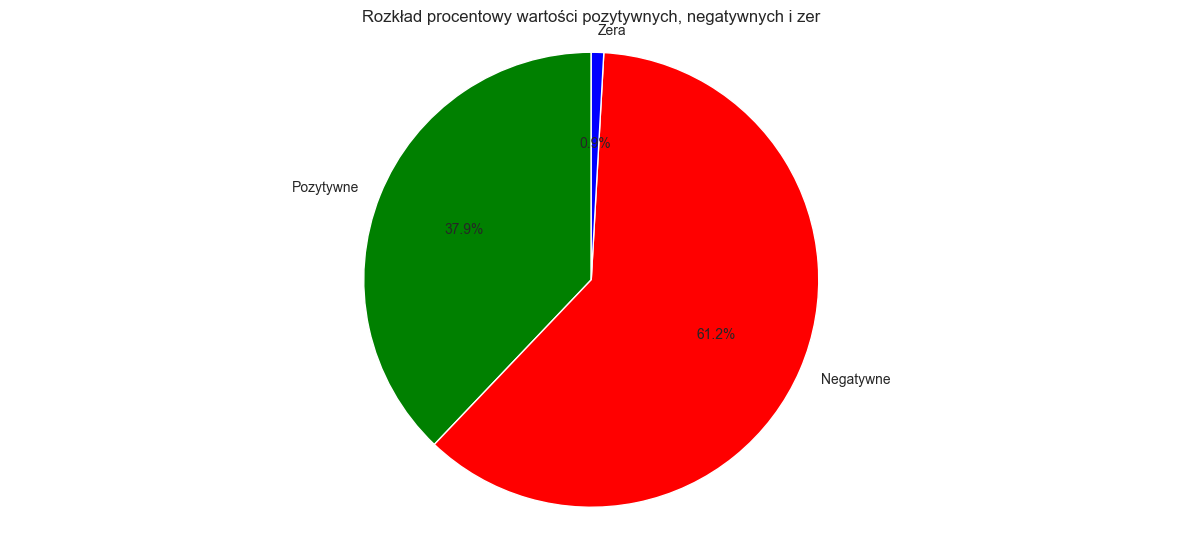

In [419]:
plot_pie_chart(df_microsoft_monthly['Close-Close Returns'])

Powyższy wykres jest tylko potwierdzeniem trendu, że wraz ze wzrostem interwału rośnie ilość wartości które są mniejsze ujemne. W przypadku interwału miesięcznego aż 61% wartości jest ujemna.

<h3>Analiza wartości odstających dla microsoft_quarterly.db</h3>

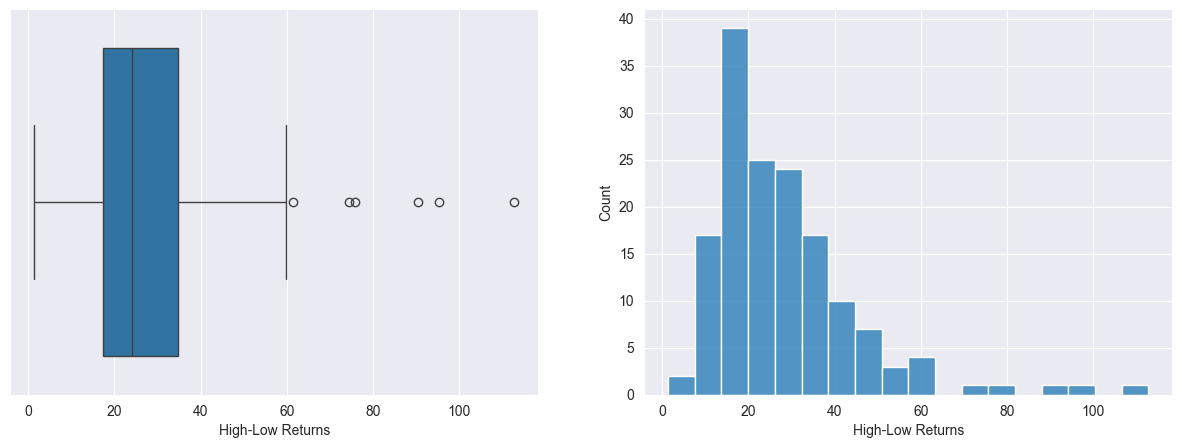

In [420]:
draw_plots(df_microsoft_quarterly, "High-Low Returns")

In [421]:
show_tab(outliers, df_microsoft_quarterly['High-Low Returns'])

----------------------------  -----
Kwartyl dolny Q1:             17.33
Kwartyl górny Q3:             34.84
Odstęp międzykwartylowy IQR:  17.51
Lewy wąs:                     -8.94
Prawy wąs:                    61.1
----------------------------  -----


Dla tak dużego interwału ogromne są też wachania cenowe instrumentu finansowego. Q1 wynosi 17.33% a Q3 az 34.84%.

In [422]:
show_tab(outliers_in_percentage, df_microsoft_quarterly['High-Low Returns'])

-------------------------------  ----
Ilość wartości za lewym wąsem:   0
Ilość wartości za prawym wąsem:  6
Procentowa wartości poza wąsami  3.92
-------------------------------  ----


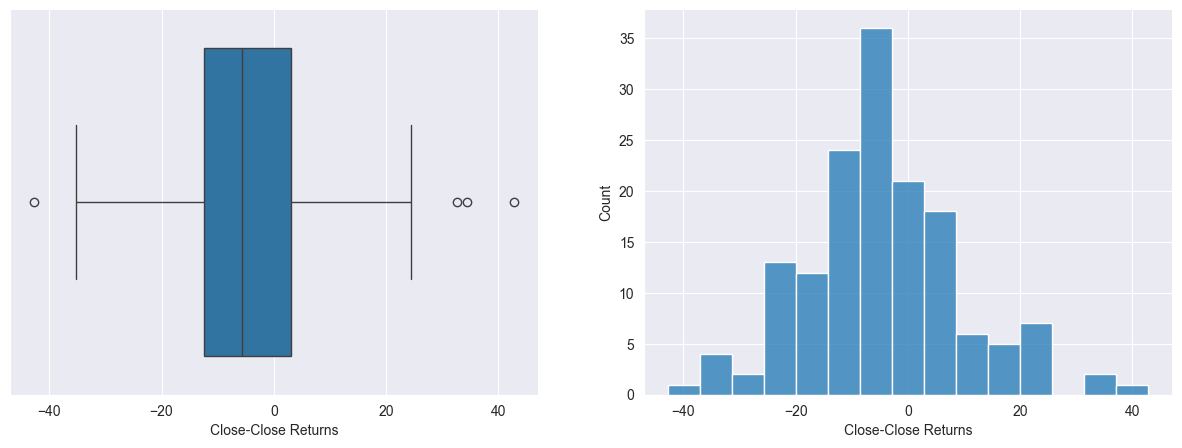

In [423]:
draw_plots(df_microsoft_quarterly, "Close-Close Returns")

In [424]:
show_tab(outliers, df_microsoft_quarterly['Close-Close Returns'])

----------------------------  ------
Kwartyl dolny Q1:             -12.35
Kwartyl górny Q3:               3.02
Odstęp międzykwartylowy IQR:   15.37
Lewy wąs:                     -35.41
Prawy wąs:                     26.08
----------------------------  ------


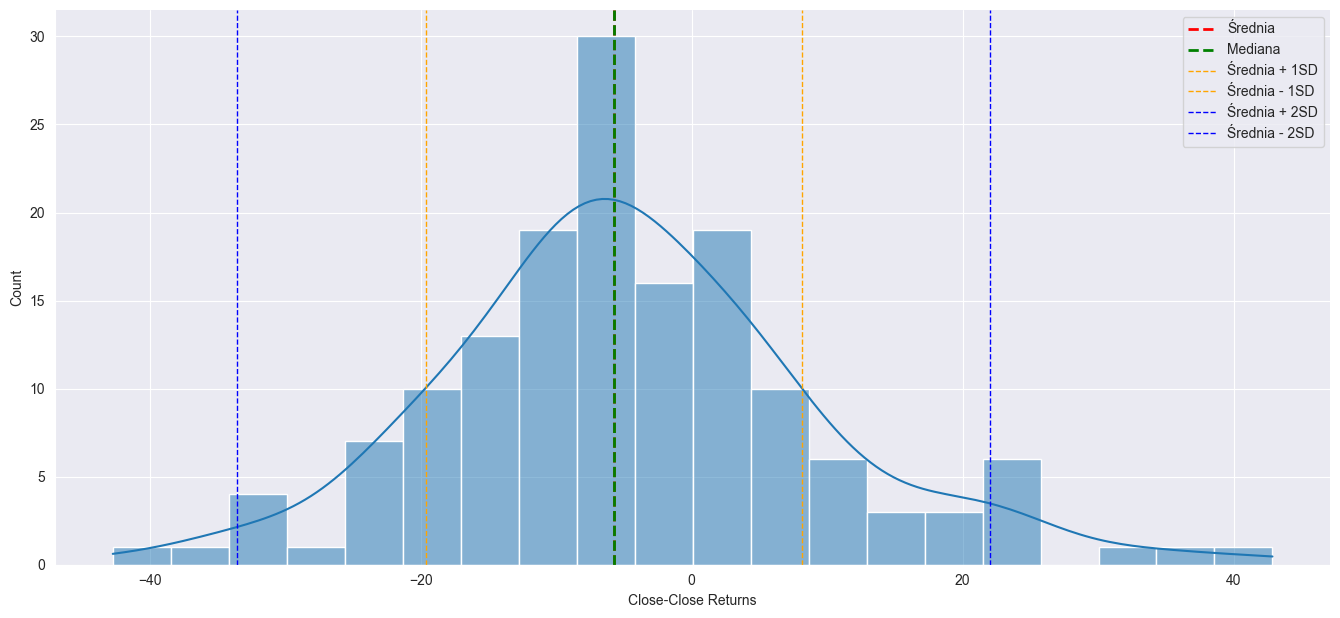

In [425]:
distribution_chart(df_microsoft_quarterly['Close-Close Returns'],df_microsoft_quarterly['Close-Close Returns'],20)

Mediana dla tak dużego interwału jest jeszcze bardziej 'na lewo' od zera. Odhylenie średnie wynoski dwadzieścia kilka procent.

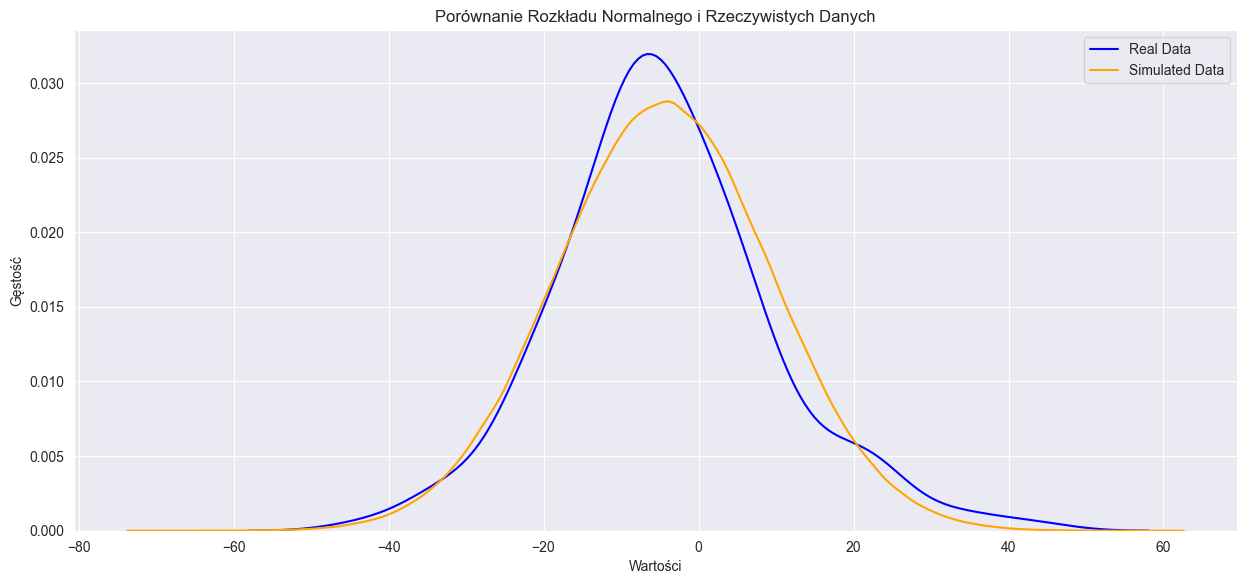

In [426]:
compare_with_normal_distribution(df_microsoft_quarterly['Close-Close Returns'])

Rozkład empiryczny jest jeszcze widocznie mniej wyostrzony niż rozkład dla mniejszych interwałów.

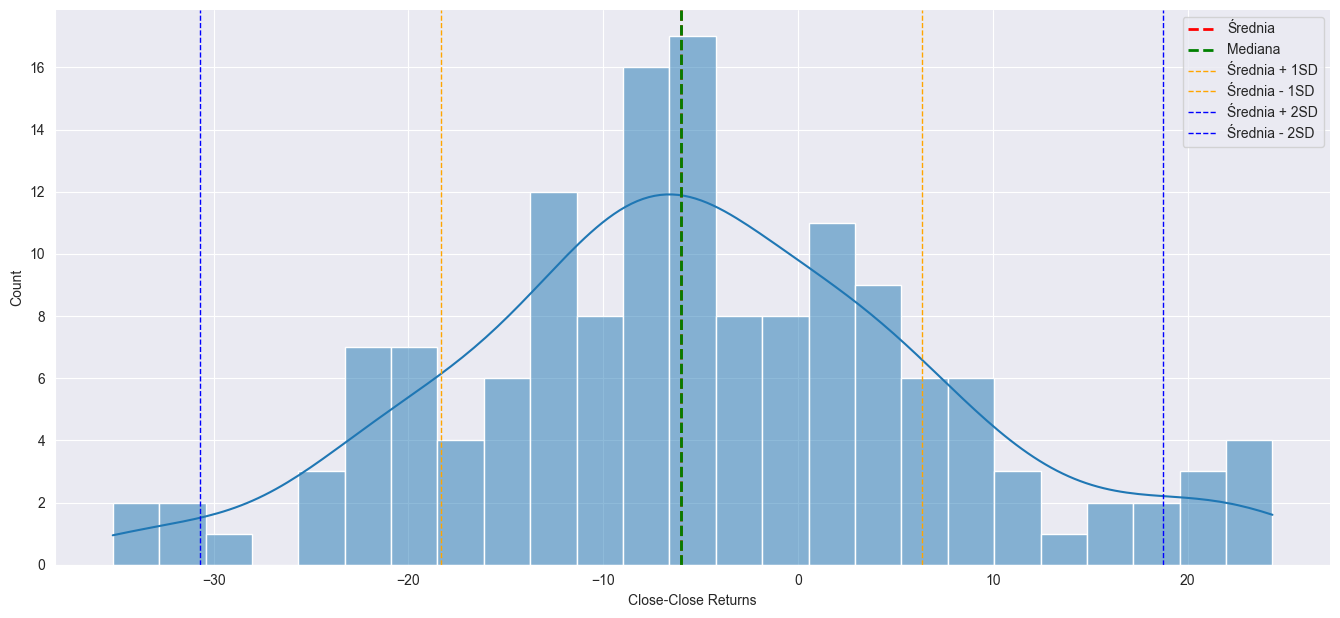

In [427]:
data = df_microsoft_quarterly['Close-Close Returns']

Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1
left = Q1 - 1.5 * IQR
right = Q3 + 1.5 * IQR

# Wybieramy wartości pomiędzy left a right
selected_values = data[(data >= left) & (data <= right)]
distribution_chart(selected_values, selected_values,25 )

Rozkład dla odfiltrowanych wartości odstających.

In [428]:
df_microsoft_quarterly['Close-Close Returns'] = df_microsoft_quarterly['Close-Close Returns'].fillna(0)

In [429]:
show_tab(pos_indicators,df_microsoft_quarterly['Close-Close Returns'])

-------------------------  ------
Najmniejsza wartość (min)  -42.71
Największa wartość (max)    42.86
Średnia arytmetyczna        -4.46
Kwantyl pierwszy (Q1)      -12.34
Mediana (Q2)                -5.57
Kwantyl trzeci (Q3)          2.98
-------------------------  ------


In [430]:
show_tab(scatter_indicators, df_microsoft_quarterly['Close-Close Returns'])

------------------------------------------------  ---------------------------
Odchylenie standardowe                            13.85
Wariancja                                         191.73
Rozstęp między skrajnymi wartościami (max - min)  85.57
Rozstęp międzykwartylowy (IQR)                    15.32
Odchylenie ćwiartkowe                             7.66
Współczynnik asymetrii (skośności)                0.40 (prawostronnie skośny)
Kurtoza                                           3.91
Współczynnik wyostrzenia                          0.91 (leptokurtyczny)
------------------------------------------------  ---------------------------


Charakter wykresu nie zmienia sie, dalej jest leptokurtyczny, jednak współczynnik wyostrzeniwynosi tylko 0.91, to niewiele w porównaniu dla współczynnika dla interwału 1dniowego, gdize wynosił on około 23. Odchylenie standardowe wynosi 13% .

In [431]:
intervals_prob = compute_intervals_probability(df_microsoft_quarterly['Close-Close Returns'],10)
intervals_prob

(-42.8, -34.157]     0.013072
(-34.157, -25.6]     0.032680
(-25.6, -17.043]     0.111111
(-17.043, -8.485]    0.209150
(-8.485, 0.0717]     0.307190
(0.0717, 8.629]      0.189542
(8.629, 17.186]      0.058824
(17.186, 25.743]     0.058824
(25.743, 34.3]       0.006536
(34.3, 42.857]       0.013072
Name: proportion, dtype: float64

Prawie połowa danych leży pomiedzy -8.5% a 8.5%

In [432]:
compute_cumulative_intervals_probability(intervals_prob)

(-42.8, -34.157]     0.013072
(-34.157, -25.6]     0.045752
(-25.6, -17.043]     0.156863
(-17.043, -8.485]    0.366013
(-8.485, 0.0717]     0.673203
(0.0717, 8.629]      0.862745
(8.629, 17.186]      0.921569
(17.186, 25.743]     0.980392
(25.743, 34.3]       0.986928
(34.3, 42.857]       1.000000
Name: proportion, dtype: float64

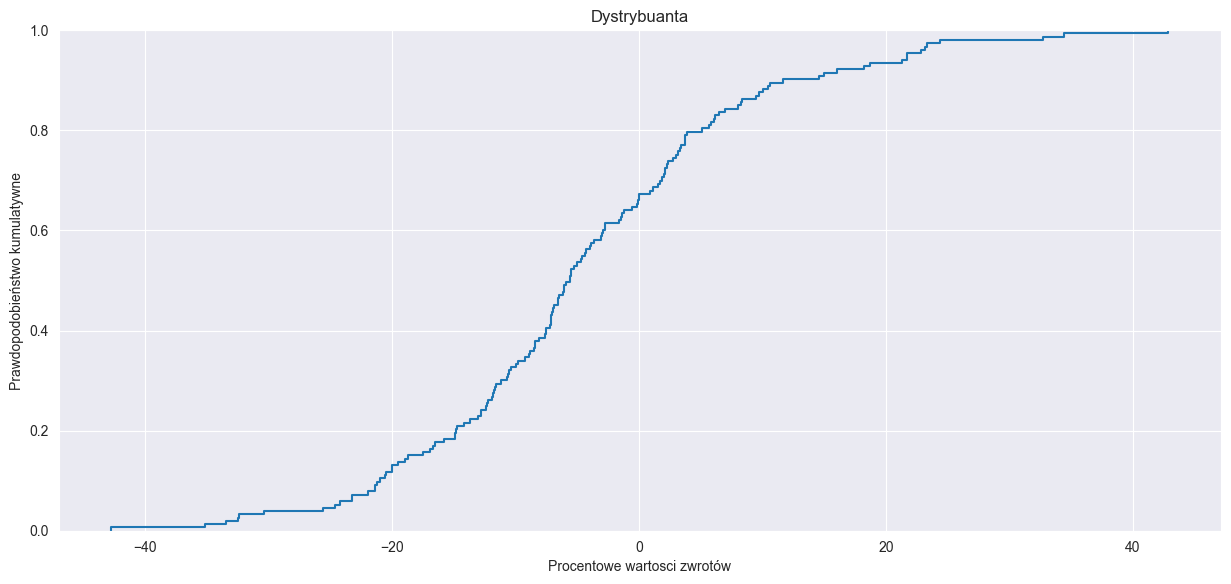

In [433]:
distribuant(df_microsoft_quarterly['Close-Close Returns'])

Dystrubuanta empiryczna z racji niewielkiej liczby danych jest bardziej skokowa, porównując z niższymi interwałami.

In [434]:
count_frequency_intervals(df_microsoft_quarterly['Close-Close Returns'],10)

Close-Close Returns
(-42.8, -34.157]      2
(-34.157, -25.6]      5
(-25.6, -17.043]     17
(-17.043, -8.485]    32
(-8.485, 0.0717]     47
(0.0717, 8.629]      29
(8.629, 17.186]       9
(17.186, 25.743]      9
(25.743, 34.3]        1
(34.3, 42.857]        2
Name: count, dtype: int64

In [435]:
show_tab(additional_statistics,df_microsoft_quarterly['Close-Close Returns'])

----------------------------  ------
Liczba wartości pozytywnych:   50
Liczba wartosci negatywnych:  102
Liczba wystepowania zer:        1
Procent dodatnich wartości:    32.68
Procent negatywych wartosci:   66.67
Procent wystepowania zer:       0.65
Średni pozytywny zwrot:        10.56
Średni negatywny zwrot:       -11.87
----------------------------  ------


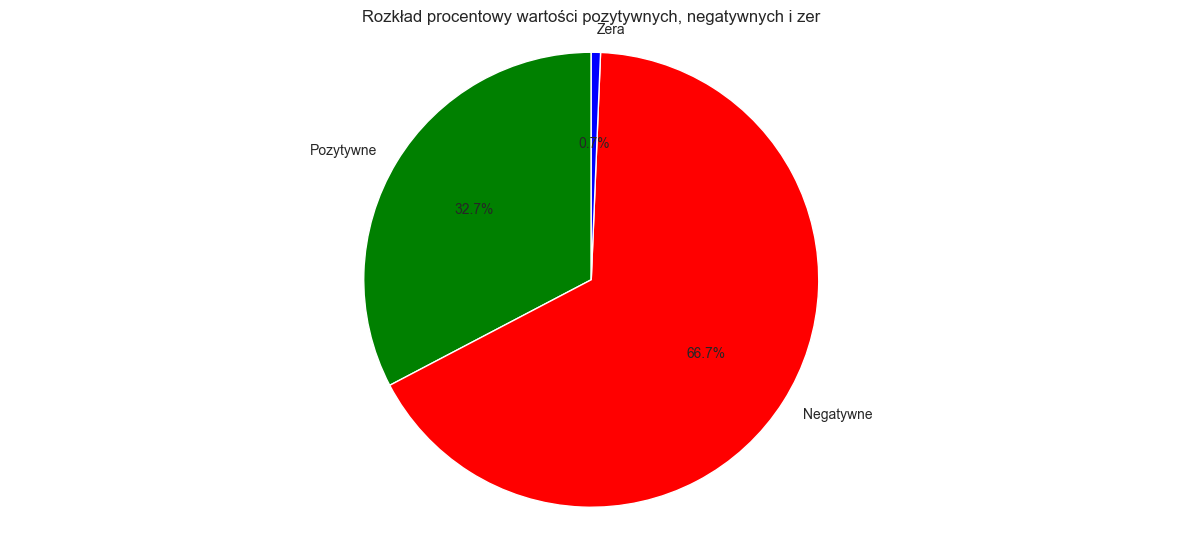

In [436]:
plot_pie_chart(df_microsoft_quarterly['Close-Close Returns'])

Wykres potwierdza nasze przypuszczenia z początku analizy szczegółowej interwałów. Wraz ze wzrostem interwału rośnie prawdopodobieństwo, że zwrot będzie miał wartość ujemną. Tylko 1/3 wszystkich wartości jest dodatnia.

<h3>Testy statystyczne</h3>

W tej sekcji przeprowadziłem kilka testów statystycznych, które głownie sprawdzały zbieżność do rozkładu normalnego.

**Test D'Agostino-Pearsona**

Test normalności D'Agostino-Pearsona to statystyczny test używany do oceny, czy próbka danych pochodzi z rozkładu normalnego. Test ten bazuje na trzecim i czwartym momentach statystyki, czyli na  kurtozie i skośności.
Statystyka testowa ma postać:
$K^2 = Z^2_{A} +Z^2_{K}$

gdzie:
$\ Z^2_{A}$ : statystyka testowa testu skośności
$\ Z^2_{K}$ : statystyka testowa testu kurtozy.

$H_{0}$ - próbka pochodzi z rozkładu normalnego
$H_{1}$ - próbka nie pochodzi z rozkładu normalnego

Za hipotezę zerową uznajemy $H_{0}$ - próbka pochodzi z rozkładu normalnego natomiast hipotezą alternatywna jest $H_{1}$

Mała wartość $p$ (zazwyczaj mniejsza niż 0,05) oznacza odrzucenie hipotezy zerowej, co sugeruje, że dane nie pochodzą z rozkładu normalnego.
Wartość p większa niż 0,05 nie dostarcza wystarczających dowodów na odrzucenie hipotezy zerowej, co sugeruje, że dane mogą pochodzić z rozkładu normalnego.


In [437]:
column = 'Close-Close Returns'
interval = '1week interval'
stat, p  = stats.normaltest(df_microsoft_daily[column])
print(interval + " for " +column + " -> ""p_value: ", p)

1week interval for Close-Close Returns -> p_value:  0.0


p_value jest tak małe dla kolumny 'Close-Close Returns' na interwale 1dniowym, że wykonanie testu statystycznego zwraca 0 dla p.
Oznacza to odrzucenie hipotezy zerowej i przyjumjemy, że próbka nie pochodzi z rozkładu normalnego.

In [438]:
column = 'Close-Close Returns'
interval = '1week interval'
stat, p  = stats.normaltest(df_microsoft_weekly[column])
print(interval + " for " +column + " -> ""p_value: ", p)

1week interval for Close-Close Returns -> p_value:  2.352857091707279e-58


Dla interwału tygodniowego dalej p < 0.05 co oznacza odrzucenie hipotezy zerowej i uznanie, że próbka nie pochodzi z rozkładu normalnego.

In [439]:
column = 'Close-Close Returns'
interval = '1month interval'
stat, p  = stats.normaltest(df_microsoft_monthly[column])
print(interval + " for " +column + " -> ""p_value: ", p)

1month interval for Close-Close Returns -> p_value:  2.4333937211601935e-14


Dla interwału miesiecznego p < 0.05 co oznacza odrzucenie hipotezy zerowej i uznanie, że próbka nie pochodzi z rozkładu normalnego.

In [440]:
column = 'Close-Close Returns'
interval = '1quarter interval'
stat, p  = stats.normaltest(df_microsoft_quarterly[column])
print(interval + " for " +column + " -> ""p_value: ", p)

1quarter interval for Close-Close Returns -> p_value:  0.015294086681270911


W przypadku interwału 3miesięcznego dalej p< 0.05 co oznacza, że musimy odrzucić hipotezę zerową o pochodzeniu próbki z rozkładu normalnego.
Na przykładzie tego testu dobrze jest widać, jaki wpływ ma wielkość próbki na test statystyczny. Im większa była próbka tym byliśmy bardziej pewni, że dane nie pochodzą z rozkładu normalnego.

Sprawdźmy teraz co sie stanie po usunięciu wartości odstających:

In [441]:
column = 'Close-Close Returns'
interval = '1day interval'

data = df_microsoft_daily[column]
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1
left = Q1 - 1.5 * IQR
right = Q3 + 1.5 * IQR

# Wybieramy wartości pomiędzy left a right
selected_values = data[(data >= left) & (data <= right)]

stat, p  = stats.normaltest(selected_values)
print(interval + " for " +column + " -> ""p_value: ", p)

1day interval for Close-Close Returns -> p_value:  0.8550687709865327


In [442]:
column = 'Close-Close Returns'
interval = '1week interval'

data = df_microsoft_weekly[column]
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1
left = Q1 - 1.5 * IQR
right = Q3 + 1.5 * IQR

# Wybieramy wartości pomiędzy left a right
selected_values = data[(data >= left) & (data <= right)]

stat, p  = stats.normaltest(selected_values)
print(interval + " for " +column + " -> ""p_value: ", p)

1week interval for Close-Close Returns -> p_value:  0.9951575661291728


In [443]:
column = 'Close-Close Returns'
interval = '1month interval'

data = df_microsoft_monthly[column]
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1
left = Q1 - 1.5 * IQR
right = Q3 + 1.5 * IQR

# Wybieramy wartości pomiędzy left a right
selected_values = data[(data >= left) & (data <= right)]

stat, p  = stats.normaltest(selected_values)
print(interval + " for " +column + " -> ""p_value: ", p)

1month interval for Close-Close Returns -> p_value:  0.5999946816674104


In [444]:
column = 'Close-Close Returns'
interval = '3months interval'

data = df_microsoft_quarterly[column]
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1
left = Q1 - 1.5 * IQR
right = Q3 + 1.5 * IQR

# Wybieramy wartości pomiędzy left a right
selected_values = data[(data >= left) & (data <= right)]

stat, p  = stats.normaltest(selected_values)
print(interval + " for " +column + " -> ""p_value: ", p)

3months interval for Close-Close Returns -> p_value:  0.6799993199084604


Po odfiltrowaniu wartości odstjacych z danych, zauważamy trend zupełnie odwrotny. Dla interwału dniowego wartość p przyjmuje prawie 1 i jest większe od 0.05 w każdym z interwałów co powoduje, że ne możemy odrzucić hipotezy zerowej o tym, że dane pochodzą z rozkłądu normalnego.

**Test Kołmogorowa-Smirnowa**

Jest to test nieparametryczny używany do porównywania rozkładów jednowymiarowych cech statystycznych. Istnieją dwie główne wersje tego testu – dla jednej próby i dla dwóch prób. Test dla jednej próby (zwany też testem zgodności λ Kołmogorowa) sprawdza, czy rozkład w populacji dla pewnej zmiennej losowej, różni się od założonego rozkładu teoretycznego, gdy znana jest jedynie pewna skończona liczba obserwacji tej zmiennej (próba statystyczna). Często wykorzystywany jest on w celu sprawdzenia, czy zmienna ma rozkład normalny. Istnieje też wersja testu dla dwóch prób, pozwalająca na porównanie rozkładów dwóch zmiennych losowych. Jego zaletą jest wrażliwość zarówno na różnice w położeniu, jak i w kształcie dystrybuanty empirycznej porównywanych próbek.

$H_{0}$ - dwie próbki pochodzą z rozkładu normalnego
$H_{1}$ - próbki nie pochodzą z rozkładu normalnego

Dystrybuanta empiryczna $F_{n}$ dla n-elementowej próby jest zdefiniowana jako funkcja:

$F_{n} = \frac{1}{n}\sum_{i=1}^{n}I_{X_{i}<=x}$

gdzie:
$X_{i}$ to wartość zmiennej $X$ dla i-tej obserwacji
$I_{X_{i}<=x$ to funkcja charakterystyczna przyjmująca wartość jeden gdy $X_{i}<=x$ i zero w przeciwnym wypadku

Statystyka Kołmogorowa-Smirnowa dla danej dystrybuanty teoretycznej $F(x)$ jest dana wzorem:
$D_{n} = sup|F_{n}(x) - F(X)|$

Na mocy twierdzenia Gliwenki-Cantellego, jeśli próba pochodzi z rozkładu o dystrybuancie $F(x)$, to $D_{n}$ dąży prawie wszędzie do zera.

W celu wykonania testu Kołmogorowa-Smirnowa, skorzystamy z dostarczonej wraz z biblioteką scipy funkcji kstest

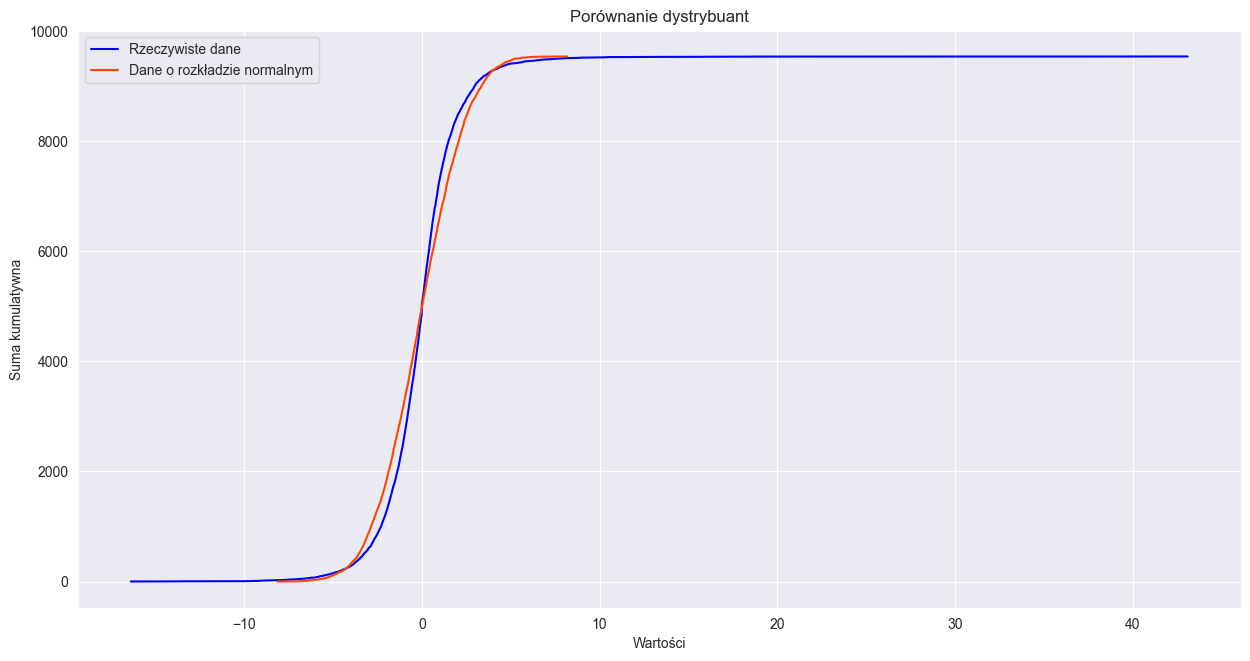

In [445]:
# Generowanie danych o rozkładzie normalnym i rysowanie wykresu porównawczego
def compare_distribuant(data):
    mean = np.mean(data)
    std = np.std(data)
    df_normal_distribution = np.random.normal(mean, std, len(data))
    
    # Obliczanie histogramów
    values, base = np.histogram(data, bins=len(data))
    values_norm, base_norm = np.histogram(df_normal_distribution, bins=len(data))
    
    # Obliczanie kumulatywnych sum
    cumulative = np.cumsum(values)
    cumulative_norm = np.cumsum(values_norm)
    
    # Rysowanie wykresu
    fig = plt.figure(figsize=(15, 7.5))
    plt.plot(base[:-1], cumulative, c='blue', label='Rzeczywiste dane')
    plt.plot(base_norm[:-1], cumulative_norm, c='orangered', label='Dane o rozkładzie normalnym')
    
    # Dodawanie legendy, tytułów i etykiet osi
    plt.legend()
    plt.title('Porównanie dystrybuant')
    plt.xlabel('Wartości')
    plt.ylabel('Suma kumulatywna')
    
    # Wyświetlanie wykresu
    plt.show()
compare_distribuant(df_microsoft_daily['Close-Close Returns'])

In [446]:
column = 'Close-Close Returns'
interval = '1day interval'
data = df_microsoft_daily[column]
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1
left = Q1 - 1.5 * IQR
right = Q3 + 1.5 * IQR

# Wybieramy wartości pomiędzy left a right
selected_values = data[(data >= left) & (data <= right)]

def kolmogorow_smirnowa_test(data):
    norm = stats.norm
    loc, scale = norm.fit(data)
    n = norm(loc=loc, scale=scale)
    statistic, p_value = stats.kstest(data, n.cdf)
    return statistic, p_value
    
stat, p = kolmogorow_smirnowa_test(df_microsoft_daily[column])
print(interval + " "+column+ " p_value ->" , p)

1day interval Close-Close Returns p_value -> 1.26185504721948e-45


Po usunięciu wartości odstających:

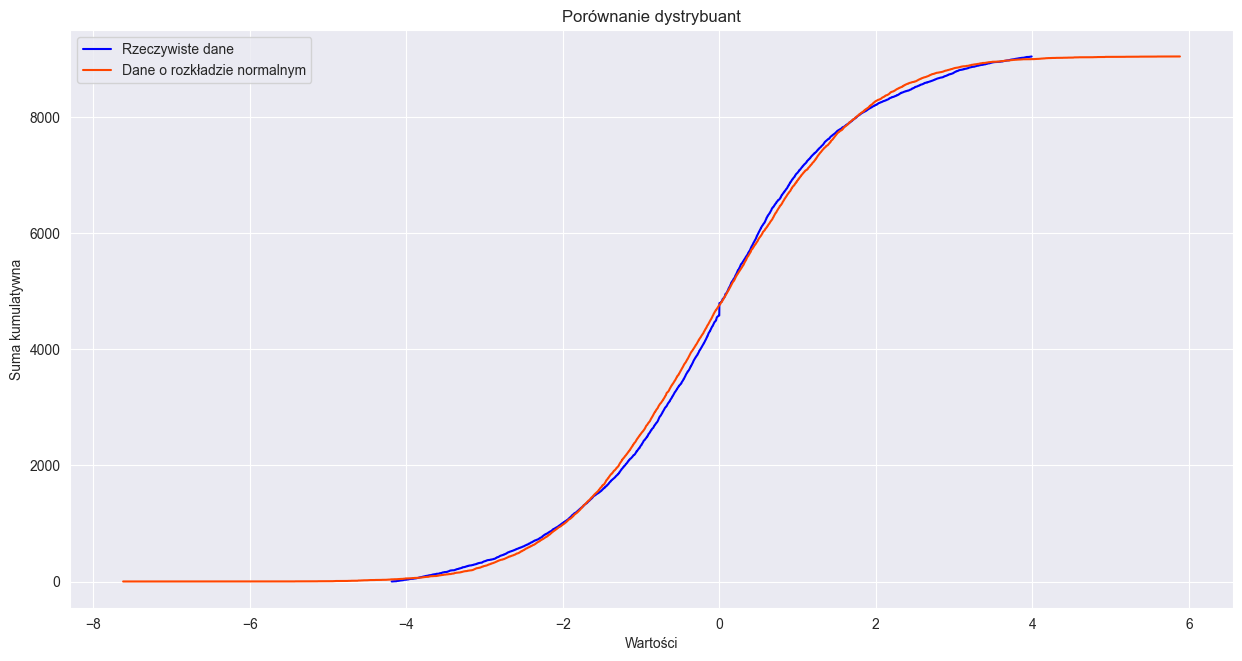

In [447]:
compare_distribuant(selected_values)

In [448]:
stat, p = kolmogorow_smirnowa_test(selected_values)
print(interval + " "+column+ " p_value ->" , p)

1day interval Close-Close Returns p_value -> 0.00012861079551999718


Przed usunięciem wartości odstajacych wynik testu sugeruje nam odrzuecenie hipotezy zerowej, swiadczy to o tym, że dane nie pochodzą z rozkładu normalnego.
Po usunięciu wartości odstających widzimy znaczy wzort wskaźnika p która jest o kilkadziesiąt rzędów wielkości większy, natomiast dalej nie pozwala nam to na nie odrzucenie hipotezy zerowej ponieważ p < 0.05.

Te same kroki wykonujemy dla interwałów tygodniowego, miesięcznego i kwartalnego.

Przed usunięciem wartości odstających:

In [449]:
column = 'Close-Close Returns'
interval = '1week interval'
data = df_microsoft_weekly[column]
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1
left = Q1 - 1.5 * IQR
right = Q3 + 1.5 * IQR
# Wybieramy wartości pomiędzy left a right
selected_values = data[(data >= left) & (data <= right)]

stat, p = kolmogorow_smirnowa_test(df_microsoft_weekly[column])
print(interval + " "+column+ " p_value ->" , p)

1week interval Close-Close Returns p_value -> 1.7735516580944154e-06


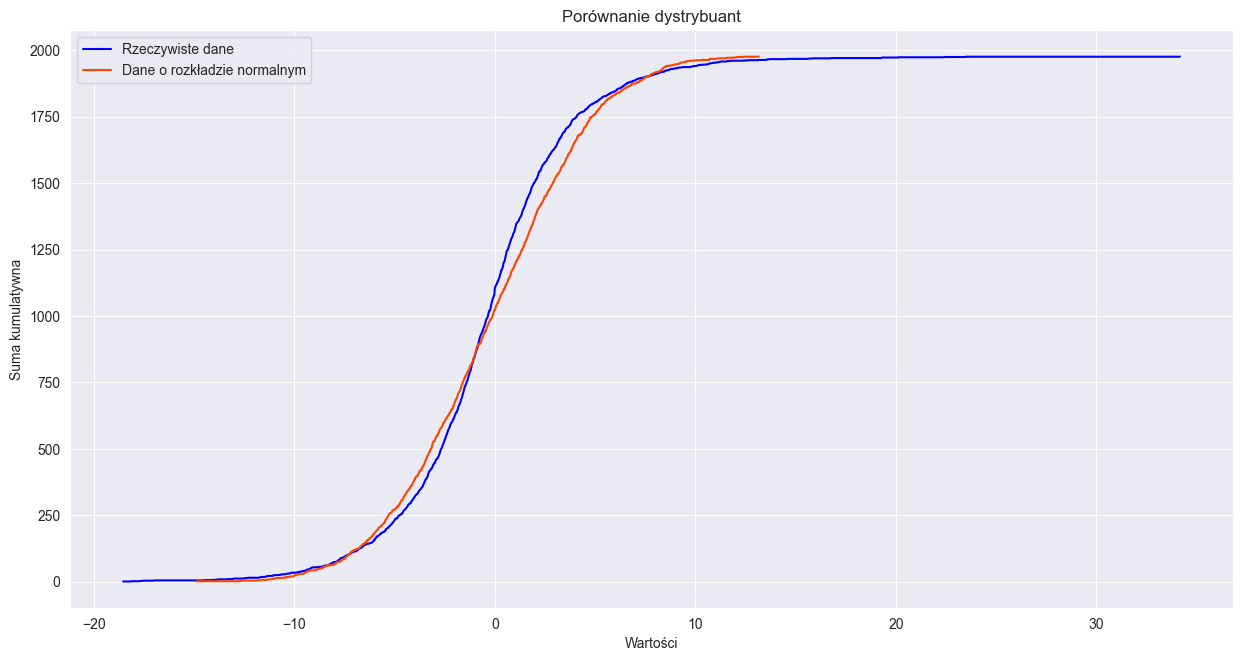

In [450]:
compare_distribuant(df_microsoft_weekly[column])

Po usunięciu wartości odstających:

In [451]:
stat, p = kolmogorow_smirnowa_test(selected_values)
print(interval + " "+column+ " p_value ->" , p)

1week interval Close-Close Returns p_value -> 0.2813768876937449


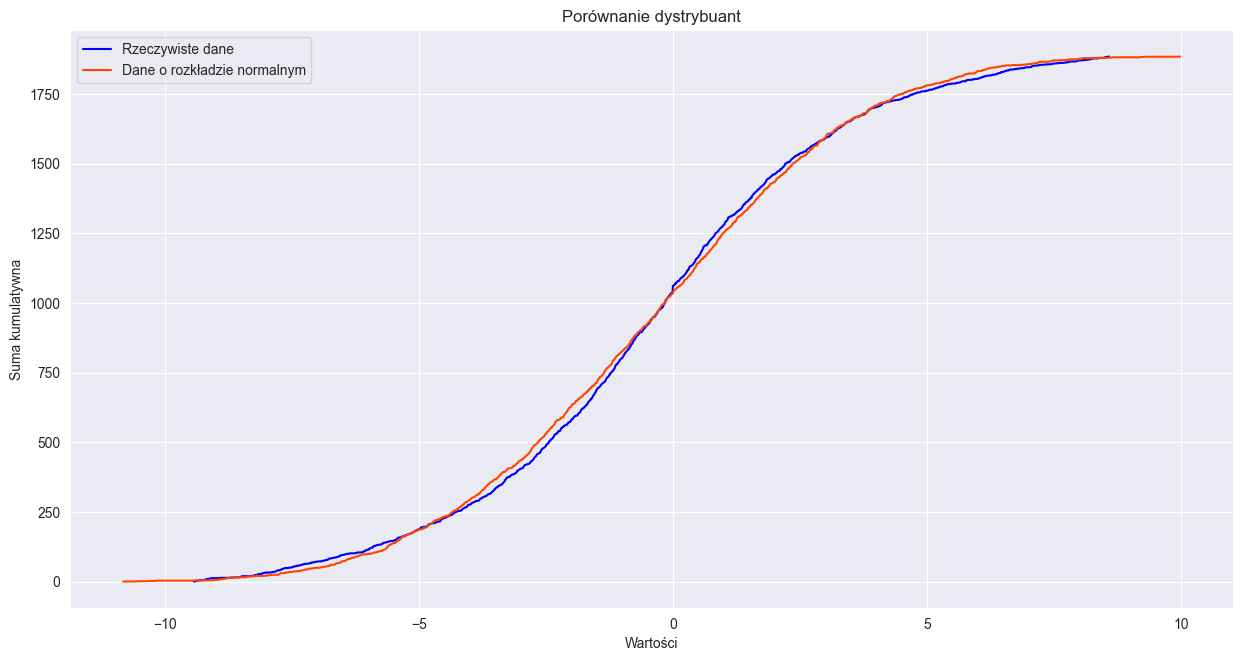

In [452]:
compare_distribuant(selected_values)

Przed usunięciem wartości odstających wynik testu wskazuje na odrzucenie hipotezy zerowej, p = 1.85 * 10^-6 i p< 0.05.
Po usunięciu wartości odstających p= 0.27 co jest wieksze od 0.05. To uniemożliwia nam odrzucenie hipotezy zerowej i możemy przyjąć, że dane mogą pochodzic z rozkładu normalnego.

Interwał miesięczny:

Przed usunięciem wartości odstających:

In [453]:
column = 'Close-Close Returns'
interval = '1month interval'
data = df_microsoft_monthly[column]
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1
left = Q1 - 1.5 * IQR
right = Q3 + 1.5 * IQR
# Wybieramy wartości pomiędzy left a right
selected_values = data[(data >= left) & (data <= right)]

stat, p = kolmogorow_smirnowa_test(df_microsoft_monthly[column])
print(interval + " "+column+ " p_value ->" , p)

1month interval Close-Close Returns p_value -> 0.048673077069572024


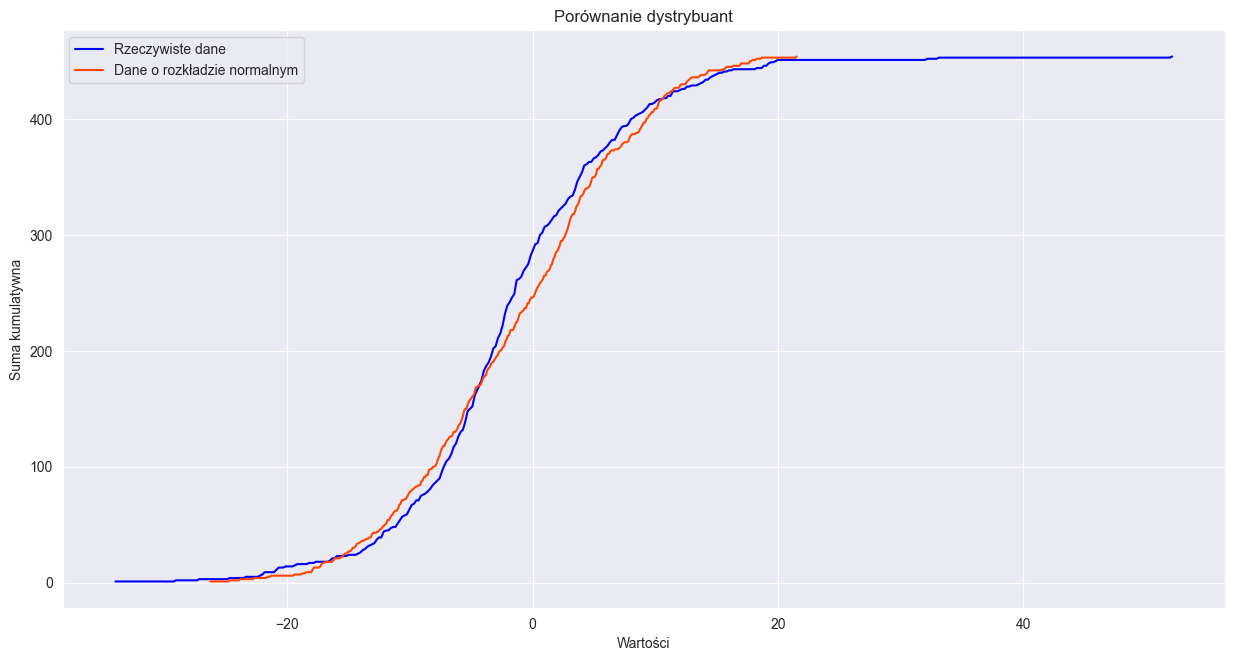

In [454]:
compare_distribuant(df_microsoft_monthly[column])

Po usunięciu wartości odstających:

In [455]:
stat, p = kolmogorow_smirnowa_test(selected_values)
print(interval + " "+column+ " p_value ->" , p)

1month interval Close-Close Returns p_value -> 0.15417181386921608


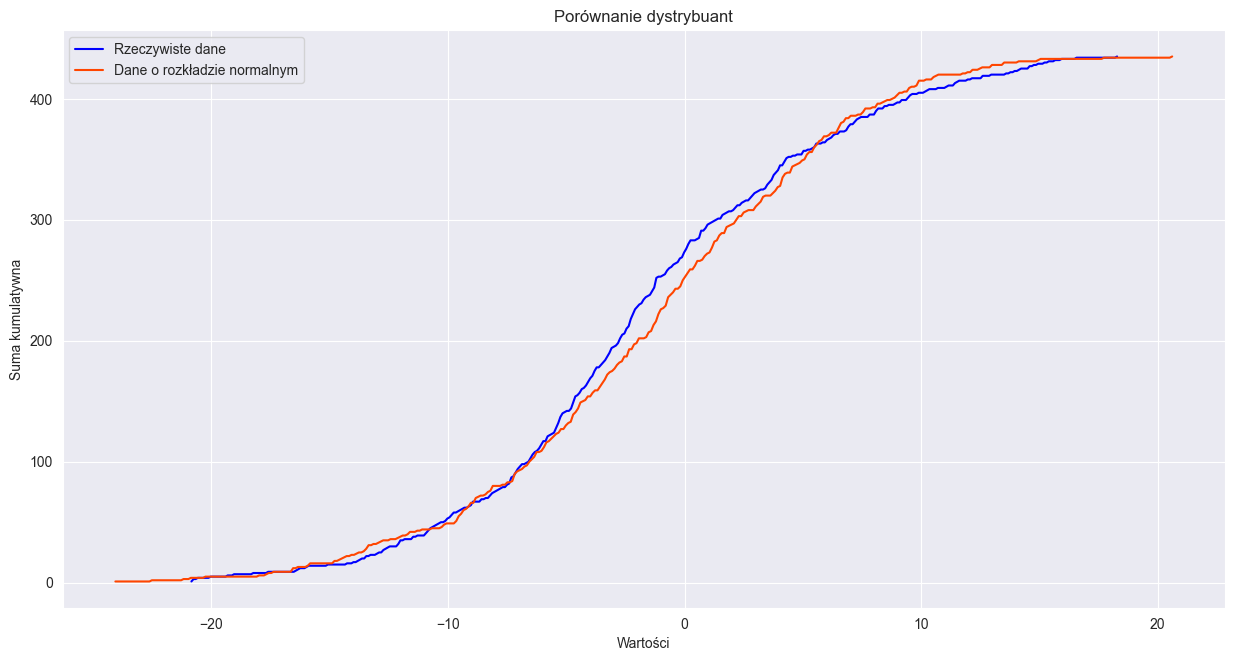

In [456]:
compare_distribuant(selected_values)

Na tym interwale sprawa wygląda podobnie jak na interwale tygodniowym, z tą różnicą, że juz w pierwszym teście bez usunięcia wartości odstających wartość p jest prawie równa 0.05 (0.047), trzymając się jednak zasad musimy odrzucić hipotezę zerową. Po odfiltrowaniu wartości odstających nie mozemy odrzucić hipotezy zerowej: p = 0.15 > 0.05.

Interwał kwartalny

Przed usunięciem wartości odstających:

In [457]:
column = 'Close-Close Returns'
interval = '3months interval'
data = df_microsoft_quarterly[column]
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1
left = Q1 - 1.5 * IQR
right = Q3 + 1.5 * IQR
# Wybieramy wartości pomiędzy left a right
selected_values = data[(data >= left) & (data <= right)]

stat, p = kolmogorow_smirnowa_test(df_microsoft_quarterly[column])
print(interval + " "+column+ " p_value ->" , p)

3months interval Close-Close Returns p_value -> 0.4132040423764657


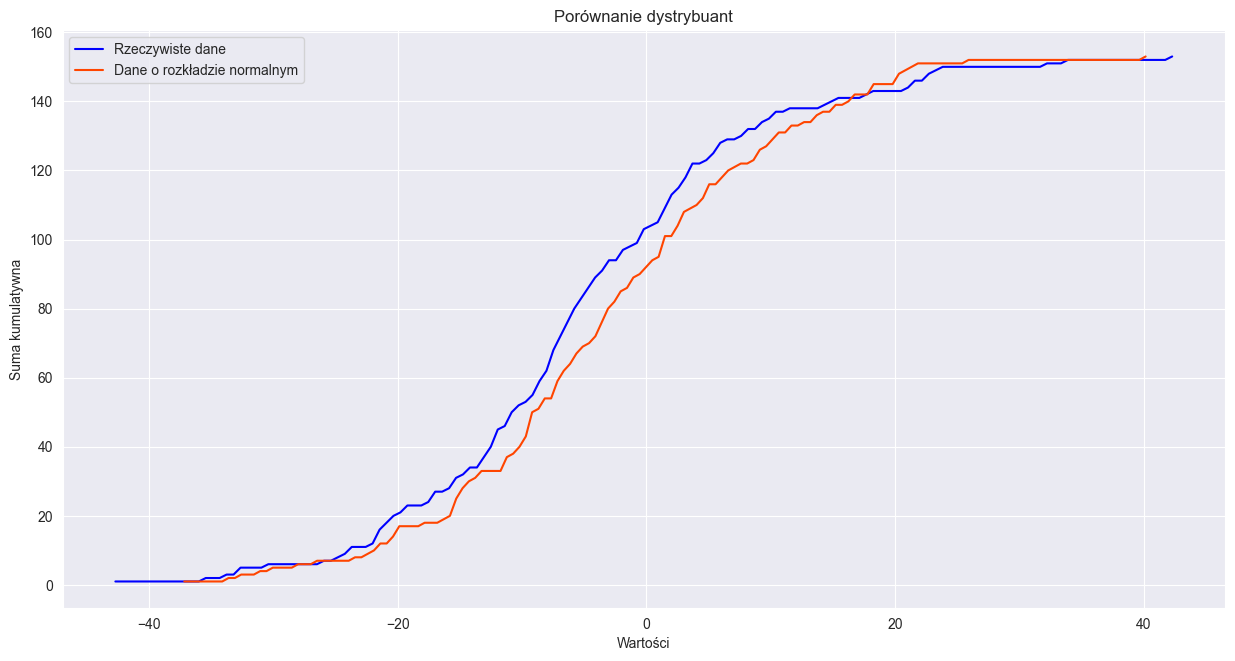

In [458]:
compare_distribuant(df_microsoft_quarterly[column])

Po usunięciu wartości odstających:

In [459]:
stat, p = kolmogorow_smirnowa_test(selected_values)
print(interval + " "+column+ " p_value ->" , p)

3months interval Close-Close Returns p_value -> 0.8190296207240978


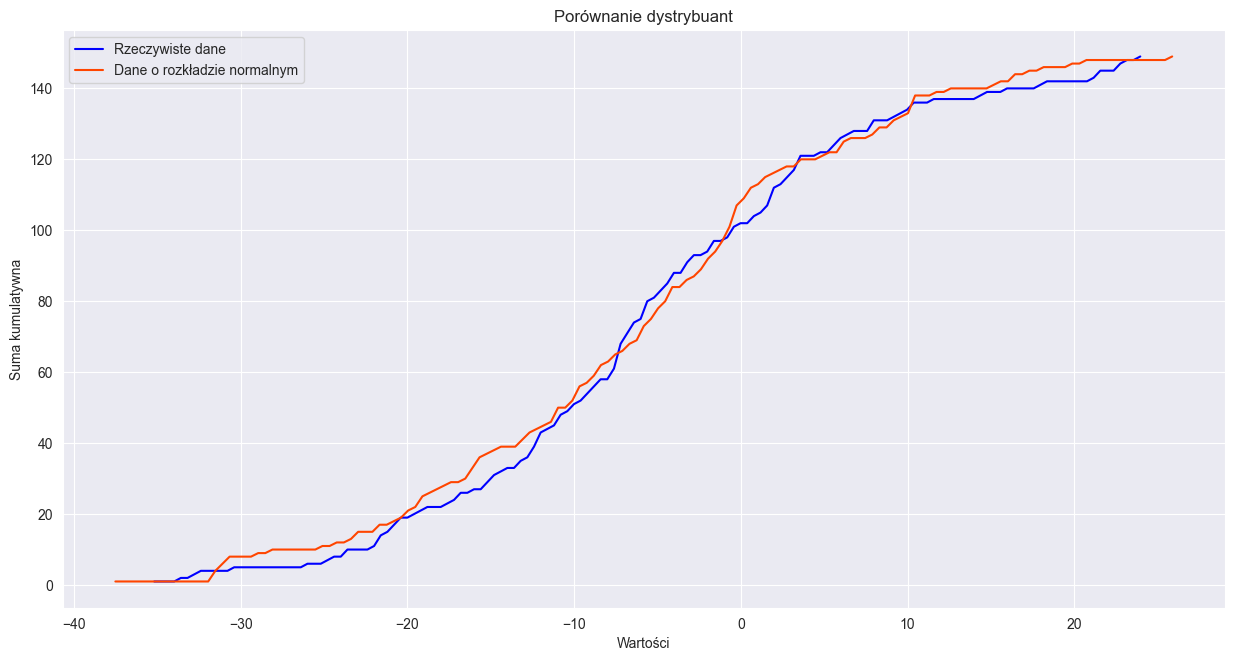

In [460]:
compare_distribuant(selected_values)

Dla interwału kwartalnego w odydwu przypadkach: przed i po usunięciu wartosci odstających nie możemy odrzucić hopotezy zerowej (p > 0.05), co pozwala nam przypuszczać, żę dane pochodzą z rozkładu normalnego, natomiast nie mamy takiej pewności. Na podstawie tych testów, możemy zauważyć, ze wraz ze spadkiem wielkości próbki zaprzeczenie hipotezie zerowej jest coraz trudniejsze, ponieważ wartość p rośnie.

**Test Shapiro-Wilka**

Jest standardowym testem wykorzystywanym do testowania normalności danych. Został opublikowany w 1965 roku przez Samuela Shapiro i Martina Wilka.
Załóżmy, że pobraliśmy próbę $x_{1},....,x_{n}$ i chcemy sprawdzić czy pochodzi z rozkładu normalnego. Hipoteza zerowa i alternatywna w teście Shapiro–Wilka ma następującą postać:
$H_{0}$ - próbka  pochodzi z rozkładu normalnego
$H_{1}$ - próbka nie pochodzi z rozkładu normalnego

W celu przeprowadzenia testu wykorzystuje się statystykę $W$:
1. Uporządkuj obserwacje niemalejąco: $y_{1} <=y_{1} ... <=y_{n} $
2. Oblicz: $S^{2} = \sum_{i=1}^{n}(y_{i} - \bar y ) =\sum_{i=1}^{n}(x_{i} - \bar x )$
3. Jeżeli n jest parzyste, niech $m = \frac{n}{2}$ w przeciwnym razie $m = \frac{n-1}{2}$
4. Używając stabelaryzowanych wartosci $a_{i}$ oblicz $b = \sum_{i=1}^{m}a_{i}(y_{n+1-i} - y_{i})$
5. Oblicz statystyke $W = \frac{b^{2}}{S^{2}}$
6. Porównaj wynik ze stabelaryzowanymi wartościami dla odpowiednich poziomów ufności i liczebności próby.

Ja natomiast skorzystam z biblioteki scipy, w której test shapiro jest już zaimplementowany. Jeżeli wartośc p bedzie większa od 0.05 to nie będziemy mogli odrzucić hipotezy zerowej $H_{0}$, kiedy jednak p < 0.05 bedziemy mogli uznać, ze próbka nie pochodzi z rozkładu normalnego - $H_{1}$


Pominę interwał jednodniowy, ponieważ dla N>5000 p_value może wyjść błędne, na interwale 1dniowym jest grubo powyżej 5000 rekordów.

Dla danych z wartościami odstającymi:

In [461]:
statistic, p_value = stats.shapiro(df_microsoft_weekly['Close-Close Returns'])
print("1week interval p -> ", p_value)

1week interval p ->  7.719591501189809e-23


In [462]:
statistic, p_value = stats.shapiro(df_microsoft_monthly['Close-Close Returns'])
print("1month interval p -> ", p_value)

1month interval p ->  3.2531524141177215e-09


In [463]:
statistic, p_value = stats.shapiro(df_microsoft_quarterly['Close-Close Returns'])
print("3months interval p -> ", p_value)

3months interval p ->  0.032205428928136826


Dla danych przefiltrowanych:

In [464]:
column = 'Close-Close Returns'
data = df_microsoft_weekly[column]
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1
left = Q1 - 1.5 * IQR
right = Q3 + 1.5 * IQR
# Wybieramy wartości pomiędzy left a right
selected_values = data[(data >= left) & (data <= right)]
statistic, p_value = stats.shapiro(selected_values)
print("1week interval p -> ", p_value)

1week interval p ->  2.7234655135544017e-05


In [465]:
column = 'Close-Close Returns'
data = df_microsoft_monthly[column]
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1
left = Q1 - 1.5 * IQR
right = Q3 + 1.5 * IQR
# Wybieramy wartości pomiędzy left a right
selected_values = data[(data >= left) & (data <= right)]
statistic, p_value = stats.shapiro(selected_values)
print("1month interval p -> ", p_value)

1month interval p ->  0.034399598836898804


In [466]:
column = 'Close-Close Returns'
data = df_microsoft_quarterly[column]
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1
left = Q1 - 1.5 * IQR
right = Q3 + 1.5 * IQR
# Wybieramy wartości pomiędzy left a right
selected_values = data[(data >= left) & (data <= right)]
statistic, p_value = stats.shapiro(selected_values)
print("3months interval p -> ", p_value)

3months interval p ->  0.18871478736400604


Dla danych nieprzefiltrowanych każdy test na każdym interwale nie spełnia warunku p>0.05, więc w każdym z tych przypadków odrzucamy hipotezę zerową. Dla danych przefiltorwanych kryterium p>0.05 spełnia tylko interwał 3miesięczny. Nie możemy odrzucić hipotezy, że dane pochodzą z rozkładu normalnego

<h3>Badanie korelacji zmiennych</h3>

Korelacja Pearsona
Zobaczmy, korzystając z macierzy korelacji, między którymi parami zmiennych istnieje najsilniejsza zależność. W tym przypadku skorzystamy ze współczynnika korelacji Pearsona, który mierzy liniową zależność między parą zmiennych.

Dla interwału 1dniowego:

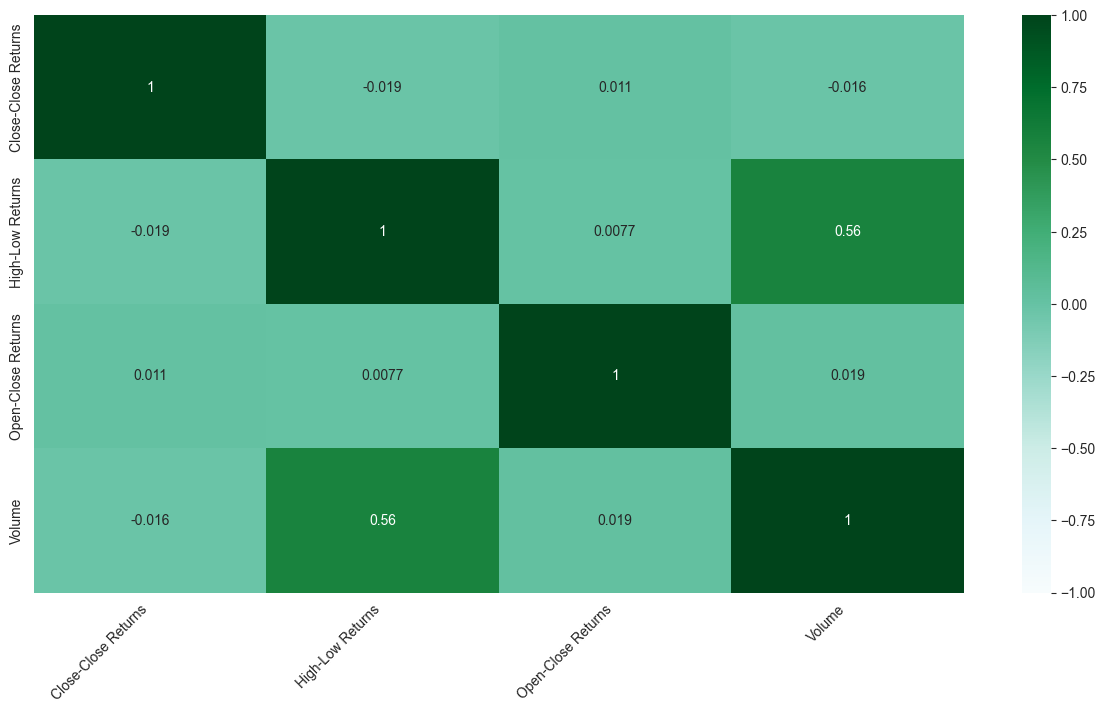

In [467]:
new_df = df_microsoft_daily[[ 'Close-Close Returns', 'High-Low Returns', 'Open-Close Returns', 'Volume']]
figure = plt.figure(figsize=(15, 7.5))
g = sns.heatmap(new_df.corr('pearson'), cmap="BuGn", vmax=1, vmin=-1, center=0, annot=True)
g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

Dla interwału 1tygodniowego:

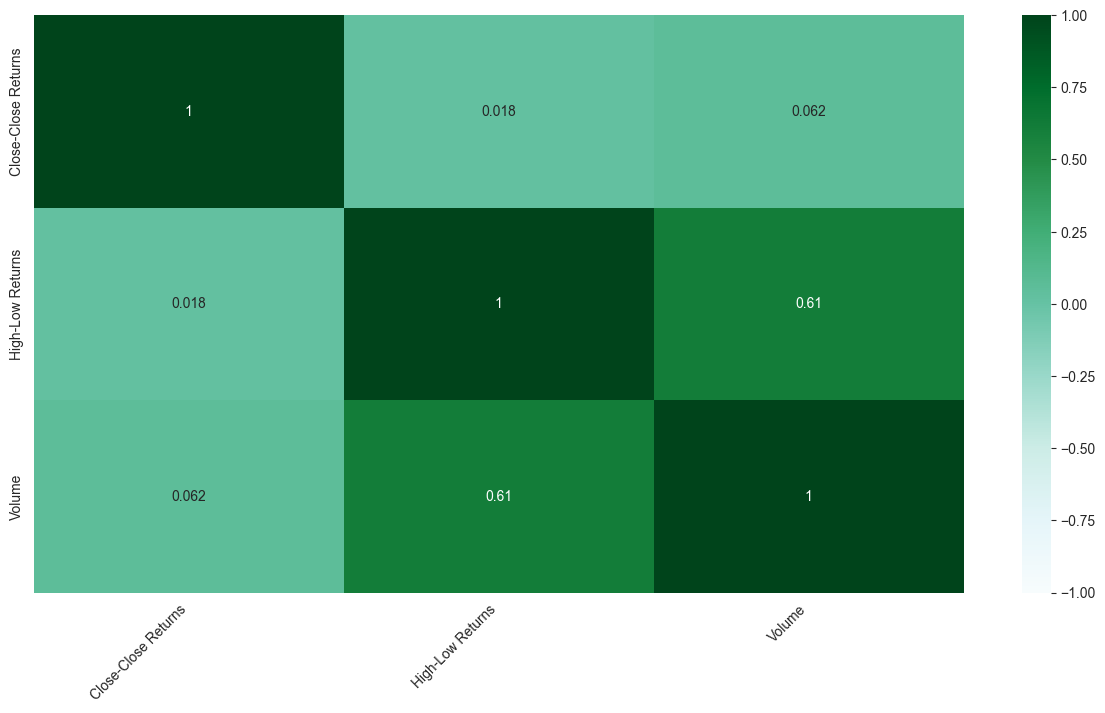

In [468]:
new_df = df_microsoft_weekly[[ 'Close-Close Returns', 'High-Low Returns', 'Volume']]
figure = plt.figure(figsize=(15, 7.5))
g = sns.heatmap(new_df.corr('pearson'), cmap="BuGn", vmax=1, vmin=-1, center=0, annot=True)
g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

DLa interwału 1miesięcznego:

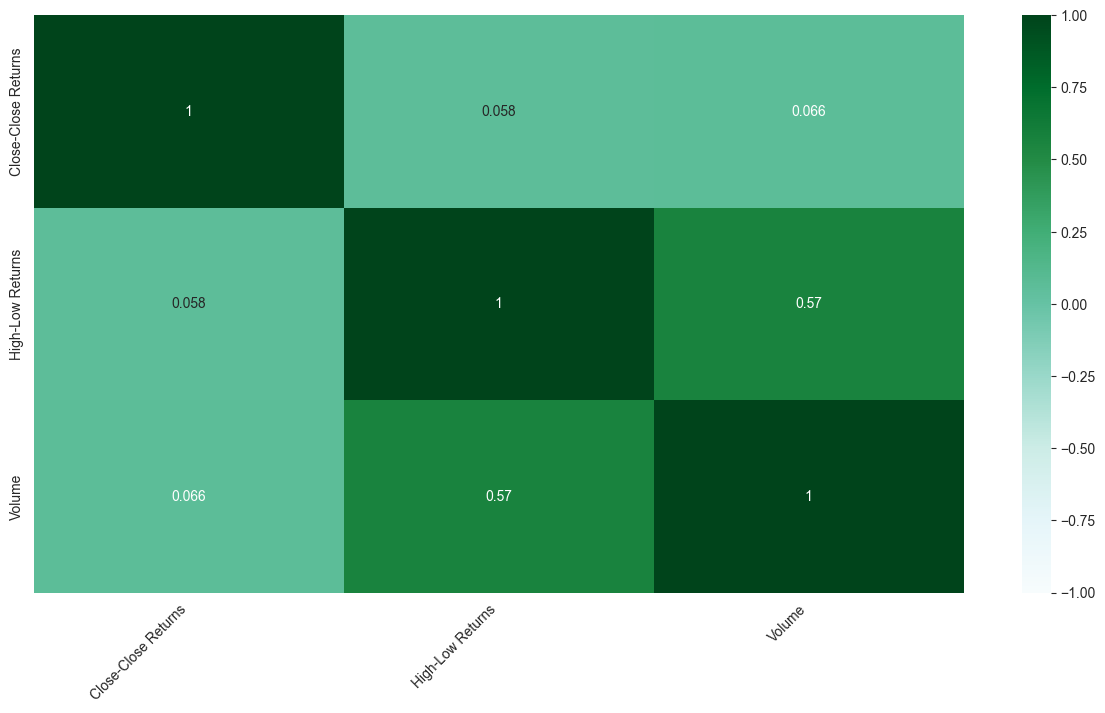

In [469]:
new_df = df_microsoft_monthly[[ 'Close-Close Returns', 'High-Low Returns', 'Volume']]
figure = plt.figure(figsize=(15, 7.5))
g = sns.heatmap(new_df.corr('pearson'), cmap="BuGn", vmax=1, vmin=-1, center=0, annot=True)
g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

Dla interwału 3miesięcznnego:

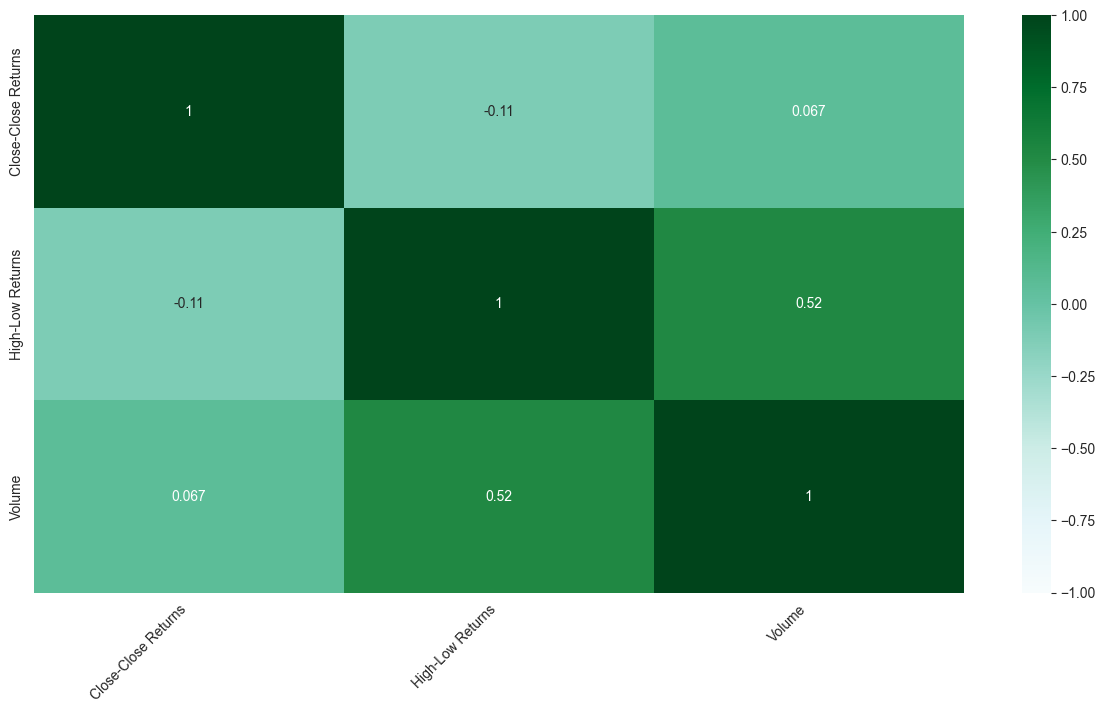

In [470]:
new_df = df_microsoft_quarterly[[ 'Close-Close Returns', 'High-Low Returns', 'Volume']]
figure = plt.figure(figsize=(15, 7.5))
g = sns.heatmap(new_df.corr('pearson'), cmap="BuGn", vmax=1, vmin=-1, center=0, annot=True)
g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

Dla wszystkichczterech interwałów, widać korelacje tylko dla kolumn:
Volume i High-Low Returns, reszta zmiennych nie wykazuje ze sobą praktycznie żadnej korelacji. Wartość w okolicach 0.50 wskazuje, że istnieje umiarkowana dodatnia korelacja między badanymi zmiennymi. Oznacza to, że zmienne te zmieniają się razem w pewien sposób, ale nie jest to związane z bardzo silną zależnością. Przypomnijmy co oznaczają zmienne Volume i High-Low Returns:
- High - najwyższa cena instrumentu finansowego osiągnięta w trakcie danego okresu czasu (np. jednej sesji handlowej). To jest największa wartość, którą osiągnęła cena w danym przedziale czasowym.

- Low - najniższa cena instrumentu finansowego osiągnięta w trakcie danego okresu czasu. To jest najmniejsza wartość, którą osiągnęła cena w danym przedziale czasowym.

- Volume - wolumen to liczba jednostek instrumentu finansowego, które zostały wymienione w danym okresie czasu. Oznacza to, ile razy dany instrument finansowy został kupiony lub sprzedany w danym przedziale czasowym.

- High-to-Low Returns [daily, weekly, monthly quarterly data]
$Formula = \frac{High_{ period [x]} - Low_{period [x]}}{Low_ {period [x]}} $

Korelacja pomiedzy High-Low Returns a Volume nie jest niespodziewana, ponieważ cena  reaguje na ilość kupionych jednostek instrumentu finansowego w jednostce czasu co przekłada sie na skoki ceny instrumentu a te skoki ceny w danym interwale reprezentuje High-Low Returns.



Do rysowania pomocniczych wykresów, w tym wykresy z dopasowną prostą posłużę się funkcjami poniżej. Ze względu na ilość danych dla interwału 1dniowego użyję wykresu kernel density. Funkcja trim_data usuwa wartości odstające, używam jej ponieważ wykres z wartościami odstającymi byłby nieczytelny. 

In [471]:
def reg_plot(data, x_col, y_col):
    g = sns.lmplot(x=x_col, y=y_col, data=data, fit_reg=False)
    sns.regplot(x=x_col, y=y_col, data=data, scatter=False, ax=g.axes[0, 0])
    g.fig.set_figwidth(15)
    g.fig.set_figheight(7.5)

In [472]:
def reg_plot_hexbin(data, x_col, y_col):
    g = sns.jointplot(x=x_col, y=y_col, data=data, kind='hex', cmap='Blues')
    g.fig.set_figwidth(15)
    g.fig.set_figheight(7.5)

In [473]:
def reg_plot_krenel_density(data, x_col, y_col):
    g = sns.jointplot(x=x_col, y=y_col, data=data, kind='kde', cmap='Blues')
    g.fig.set_figwidth(15)
    g.fig.set_figheight(7.5)

In [474]:
def trim_data(data):
    Q1 = data['High-Low Returns'].quantile(.25)
    Q3 = data['High-Low Returns'].quantile(.75)
    IQR = Q3 - Q1
    left = Q1 - 1.5*IQR
    right = Q3 + 1.5*IQR
    data =  data[(data['High-Low Returns'] >=left ) & (data['High-Low Returns'] < right)]
    
    Q1 = data['Volume'].quantile(.25)
    Q3 = data['Volume'].quantile(.75)
    IQR = Q3 - Q1
    left = Q1 - 1.5*IQR
    right = Q3 + 1.5*IQR
    data =  data[(data['Volume'] >=left ) & (data['Volume'] < right)]
    
    return data

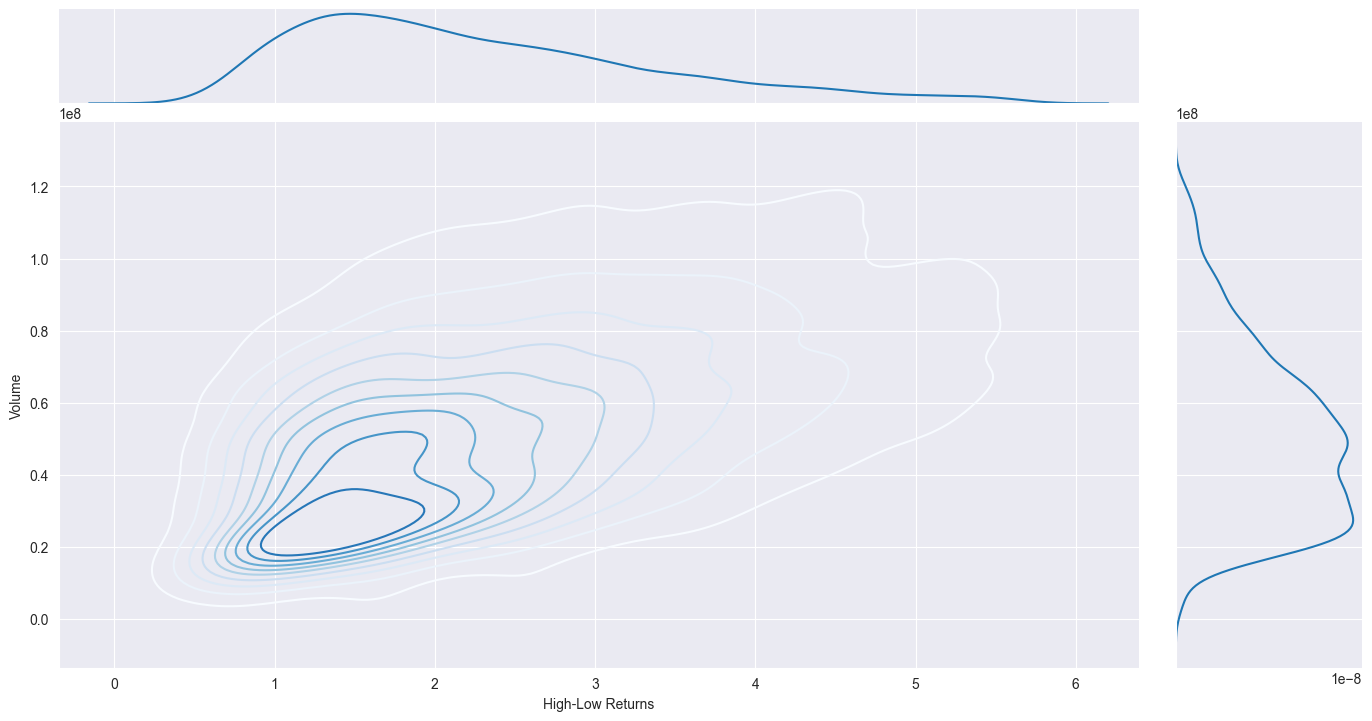

In [475]:
data = trim_data(df_microsoft_daily)
reg_plot_krenel_density(data,'High-Low Returns','Volume')

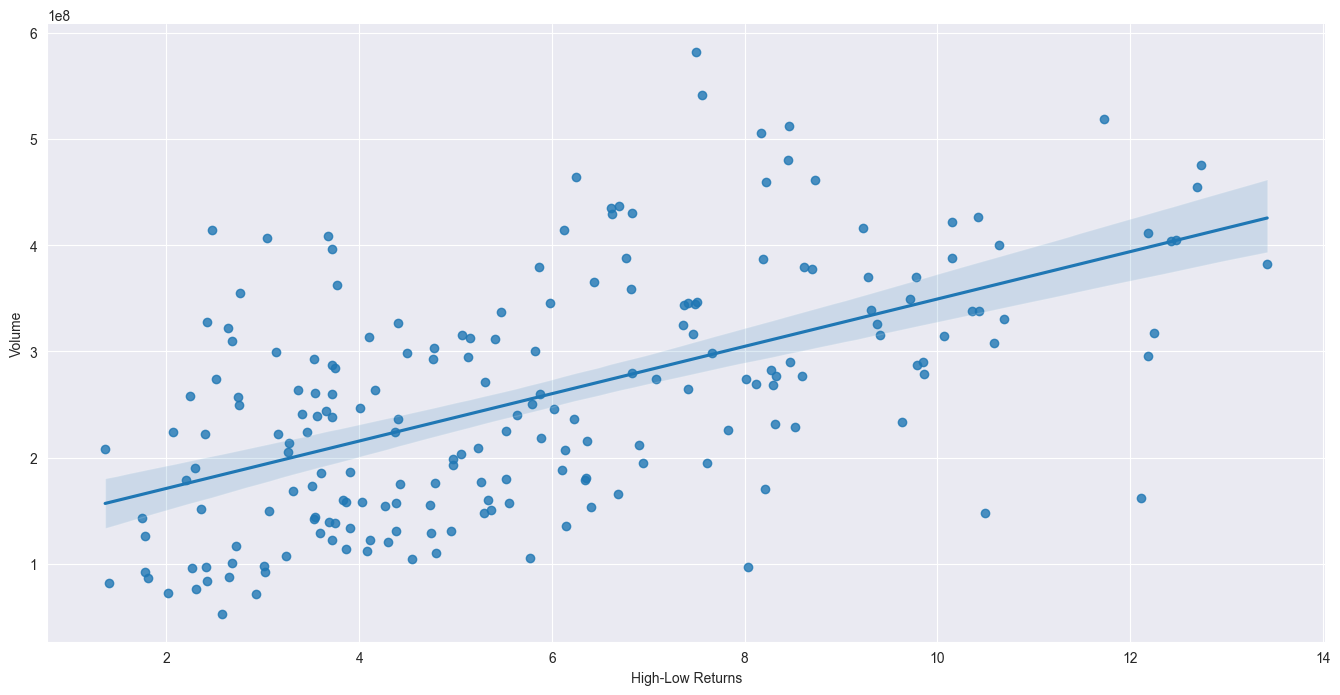

In [476]:
data = trim_data(df_microsoft_weekly)
reg_plot(data.sample(200),'High-Low Returns','Volume')

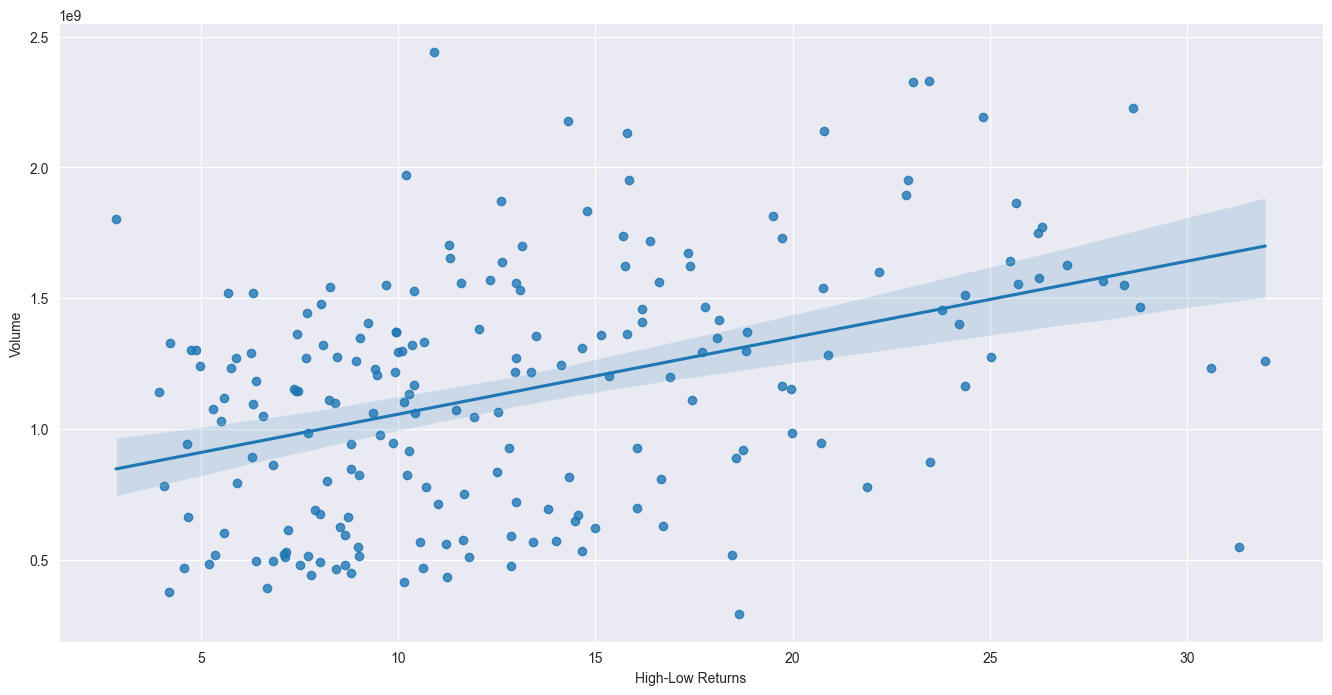

In [477]:
data = trim_data(df_microsoft_monthly)
reg_plot(data.sample(200),'High-Low Returns','Volume')

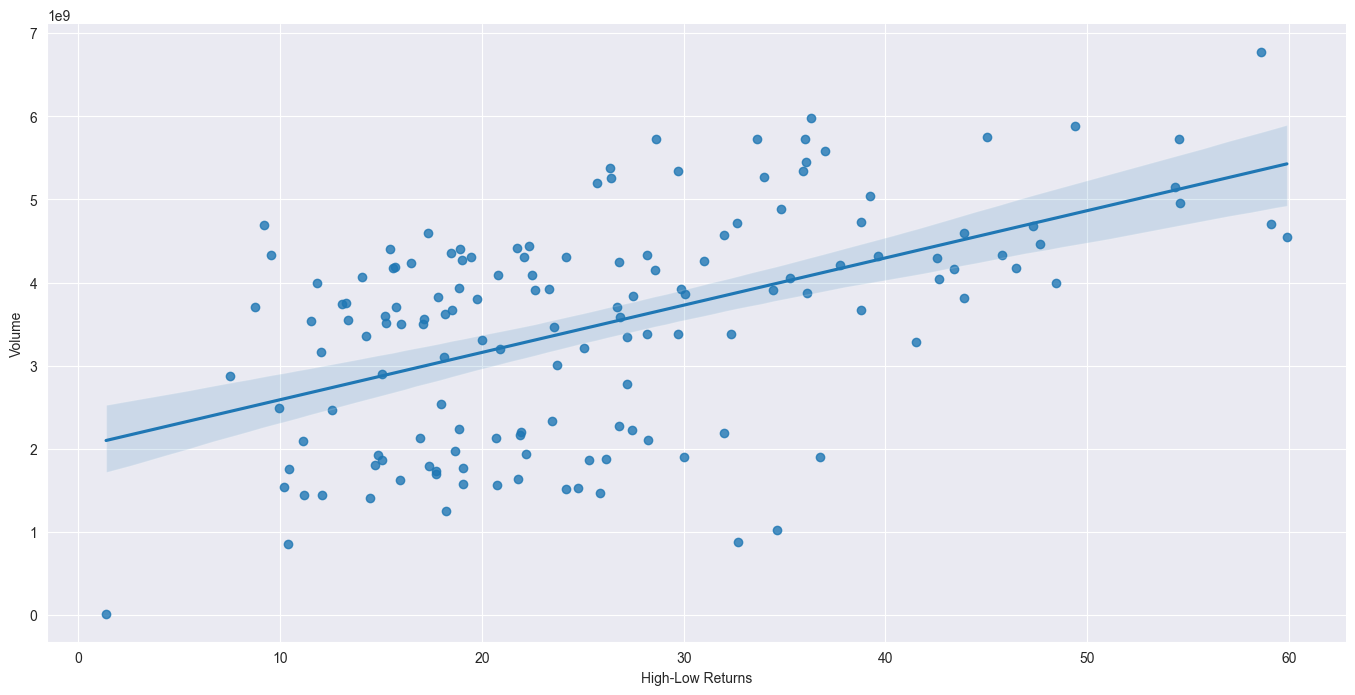

In [478]:
data = trim_data(df_microsoft_quarterly)
reg_plot(data,'High-Low Returns','Volume')